In [613]:
# initial imports
import pandas as pd
import numpy as np
from numpy import mean
from numpy import std
from math import sqrt
import itertools
from collections import Counter


In [614]:

# model tools needed
import statsmodels.api as sm
from statsmodels.formula.api import ols
import scipy.stats as stats
from scipy.stats import norm
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, LassoLarsCV, LassoLarsIC
from sklearn.svm import SVR
from sklearn.feature_selection import RFECV
from sklearn.model_selection import cross_val_score, RepeatedKFold, train_test_split, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn import neighbors
import xgboost as xgb


In [615]:
# NLP tools
# import spacy
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [616]:
# Visualization tools
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline


In [617]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None

In [618]:
# load csv file and print headers
df = pd.read_csv('../kaggleRealEstateData.csv')
df.head()

zpid          city          streetAddress  zipcode  \
0   111373431  pflugerville   14424 Lake Victor Dr    78660   
1   120900430  pflugerville     1104 Strickling Dr    78660   
2  2084491383  pflugerville    1408 Fort Dessau Rd    78660   
3   120901374  pflugerville     1025 Strickling Dr    78660   
4    60134862  pflugerville  15005 Donna Jane Loop    78660   

                                         description   latitude  longitude  \
0  14424 Lake Victor Dr, Pflugerville, TX 78660 i...  30.430632 -97.663078   
1  Absolutely GORGEOUS 4 Bedroom home with 2 full...  30.432673 -97.661697   
2  Under construction - estimated completion in A...  30.409748 -97.639771   
3  Absolutely darling one story home in charming ...  30.432112 -97.661659   
4  Brimming with appeal & warm livability! Sleek ...  30.437368 -97.656860   

   propertyTaxRate  garageSpaces  hasAssociation  hasCooling  hasGarage  \
0             1.98             2            True        True       True   
1             1.98             2            True        True       True   
2             1.98             0            True        True      False   
3             1.98             2            True        True       True   
4             1.98             0            True        True      False   

   hasHeating  hasSpa  hasView       homeType  parkingSpaces  yearBuilt  \
0        True   False    False  Single Family              2       2012   
1        True   False    False  Single Family              2       2013   
2        True   False    False  Single Family              0       2018   
3        True   False    False  Single Family              2       2013   
4        True   False    False  Single Family              0       2002   

   latestPrice  numPriceChanges latest_saledate  latest_salemonth  \
0     305000.0                5      2019-09-02                 9   
1     295000.0                1      2020-10-13                10   
2     256125.0                1      2019-07-31                 7   
3     240000.0                4      2018-08-08                 8   
4     239900.0                3      2018-10-31                10   

   latest_saleyear                                latestPriceSource  \
0             2019  Coldwell Banker United, Realtors - South Austin   
1             2020                                   Agent Provided   
2             2019                                   Agent Provided   
3             2018                                   Agent Provided   
4             2018                                   Agent Provided   

   numOfPhotos  numOfAccessibilityFeatures  numOfAppliances  \
0           39                           0                5   
1           29                           0                1   
2            2                           0                4   
3            9                           0                0   
4           27                           0                0   

   numOfParkingFeatures  numOfPatioAndPorchFeatures  numOfSecurityFeatures  \
0                     2                           1                      3   
1                     2                           0                      0   
2                     1                           0                      1   
3                     2                           0                      0   
4                     1                           0                      0   

   numOfWaterfrontFeatures  numOfWindowFeatures  numOfCommunityFeatures  \
0                        0                    1                       0   
1                        0                    0                       0   
2                        0                    0                       0   
3                        0                    0                       0   
4                        0                    0                       0   

   lotSizeSqFt  livingAreaSqFt  numOfPrimarySchools  numOfElementarySchools  \
0       6011.0          2601.0         

In [619]:
# # verifty data types
# df.dtypes

In [620]:
# get number of rows and columns - need to be > than 1k for project
df.shape


(15171, 47)

In [621]:
# change column name latestPrice to more common price
df.rename(columns={'latestPrice':'price'}, inplace=True)

In [622]:
# get list of unique data for saleyear
df['latest_saleyear'].unique()

array([2019, 2020, 2018, 2021])

In [623]:
# get the min value of sale date
df['latest_saledate'].min()

'2018-01-22'

In [624]:
# get the max value of sale date
df['latest_saledate'].max()

'2021-01-30'

In [625]:
# price apprecaiton based of df_median work
jan2018_to_2019 = .024/12
jan2019_to_2020 = .037/12
jan2020_to_2021 = .193/12

# create reverse time series number for month
for i in range(1,13):
    df['time_series'] = df['latest_salemonth'].apply(lambda x: abs(x-13))

# adjust 2018 to 2019
df.loc[df['latest_saleyear']==2018, 'adj_price'] = df.loc[df['latest_saleyear']==2018].apply(lambda x: int( (x['price'])*(1+(jan2018_to_2019*x['time_series']))*(1+(jan2019_to_2020*x['time_series']))*(1+(jan2020_to_2021*x['time_series'])) ) , axis=1 )

# adjust 2019 to 2020                                                            
df.loc[df['latest_saleyear']==2019, 'adj_price'] = df.loc[df['latest_saleyear']==2019].apply(lambda x: int( (x['price'])*(1+(jan2019_to_2020*x['time_series']))*(1+(jan2020_to_2021*x['time_series'])) ) , axis=1)
                                                                                  
# adjust 2020 to 2021
df.loc[df['latest_saleyear']==2020, 'adj_price'] = df.loc[df['latest_saleyear']==2020].apply(lambda x: int( (x['price'])*(1+(jan2020_to_2021*x['time_series'])) ), axis=1)

#copy 2021 to self
df.loc[df['latest_saleyear']==2021, 'adj_price'] = df.loc[df['latest_saleyear']==2021].apply(lambda x: int(x['price']), axis=1)

# rename original price column and make adj_price our price column
df.rename(columns={'price' : 'orig_price', 'adj_price' : 'price'}, inplace=True)

# put price as the lead in the dataframe
df.set_index('price', inplace=True)
df.reset_index(inplace=True)

In [626]:
# Classification of homeType
df['homeType'].value_counts(normalize=True)

Single Family            0.938699
Condo                    0.030980
Townhouse                0.011469
Multiple Occupancy       0.006328
Vacant Land              0.005471
Apartment                0.002439
Residential              0.002439
Mobile / Manufactured    0.001121
MultiFamily              0.000659
Other                    0.000395
Name: homeType, dtype: float64

In [627]:
# reduce dataframe to show only homeyptes of Single Family, Condo and Townhouse
df = df.loc[((df['homeType'] == 'Single Family') | (df['homeType'] == 'Condo')) | (df['homeType'] == 'Townhouse')]
df

price        zpid          city                   streetAddress  \
0      328625.0   111373431  pflugerville            14424 Lake Victor Dr   
1      309233.0   120900430  pflugerville              1104 Strickling Dr   
2      286036.0  2084491383  pflugerville             1408 Fort Dessau Rd   
3      265930.0   120901374  pflugerville              1025 Strickling Dr   
4      255324.0    60134862  pflugerville           15005 Donna Jane Loop   
...         ...         ...           ...                             ...   
15165  289006.0    29504086        austin                   9013 Marsh Dr   
15166  335307.0    29512934        austin                 905 Silcantu Dr   
15167  558845.0   241937773        austin  1413 Waterloo Shore Ln UNIT 12   
15168  875000.0    29473281        austin                   2206 S 3rd St   
15170  374900.0    29390174        austin                  3110 E 12th St   

       zipcode                                        description   latitude  \
0        78660  14424 Lake Victor Dr, Pflugerville, TX 78660 i...  30.430632   
1        78660  Absolutely GORGEOUS 4 Bedroom home with 2 full...  30.432673   
2        78660  Under construction - estimated completion in A...  30.409748   
3        78660  Absolutely darling one story home in charming ...  30.432112   
4        78660  Brimming with appeal & warm livability! Sleek ...  30.437368   
...        ...                                                ...        ...   
15165    78748  This 3 bedroom home is nestled among mature sh...  30.185915   
15166    78748  Not for rent!\n\nBeautiful one story home in T...  30.161997   
15167    78741  This contemporary three-story detached condo h...  30.240223   
15168    78704  Original bungalow with a modern addition. Larg...  30.244835   
15170    78702  3110 E 12th St, Austin, TX 78702 is a single f...  30.276930   

       longitude  propertyTaxRate  garageSpaces  hasAssociation  hasCooling  \
0     -97.663078             1.98             2            True        True   
1     -97.661697             1.98             2            True        True   
2     -97.639771             1.98             0            True        True   
3     -97.661659             1.98             2            True        True   
4     -97.656860             1.98             0            True        True   
...          ...              ...           ...             ...         ...   
15165 -97.828415             1.98             2           False        True   
15166 -97.816345             1.98             6           False        True   
15167 -97.772835             1.98             2            True        True   
15168 -97.761124             1.98             2           False        True   
15170 -97.701523             1.98             1           False        True   

       hasGarage  hasHeating  hasSpa  hasView       homeType  parkingSpaces  \
0           True        True   False    False  Single Family              2   
1           True        True   False    False  Single Family              2   
2          False        True   False    False  Single Family              0   
3           True        True   False    False  Single Family              2   
4          False        True   False    False  Single Family              0   
...          ...         ...     ...      ...            ...            ...   
15165       True        True    True    False  Single Family              2   
15166       True        True   False     True  Single Family              6   
15167       True        True    True     True  Single Family              2   
15168       True        True   False    False  Single Family              2   
15170       True        True   False     True  Single Family              1   

       yearBuilt  orig_price  numPriceChanges latest_saledate  \
0           2012    305000.0                5      2019-09-02   
1           2013    295000.0                1      2020-10-13   
2           2018    256125.0   

In [628]:
# remove duplicate long and lat which could mean duplicate listings
df[df.duplicated(subset=['latitude','longitude'], keep=False)].sort_values('latitude')

Empty DataFrame
Columns: [price, zpid, city, streetAddress, zipcode, description, latitude, longitude, propertyTaxRate, garageSpaces, hasAssociation, hasCooling, hasGarage, hasHeating, hasSpa, hasView, homeType, parkingSpaces, yearBuilt, orig_price, numPriceChanges, latest_saledate, latest_salemonth, latest_saleyear, latestPriceSource, numOfPhotos, numOfAccessibilityFeatures, numOfAppliances, numOfParkingFeatures, numOfPatioAndPorchFeatures, numOfSecurityFeatures, numOfWaterfrontFeatures, numOfWindowFeatures, numOfCommunityFeatures, lotSizeSqFt, livingAreaSqFt, numOfPrimarySchools, numOfElementarySchools, numOfMiddleSchools, numOfHighSchools, avgSchoolDistance, avgSchoolRating, avgSchoolSize, MedianStudentsPerTeacher, numOfBathrooms, numOfBedrooms, numOfStories, homeImage, time_series]
Index: []

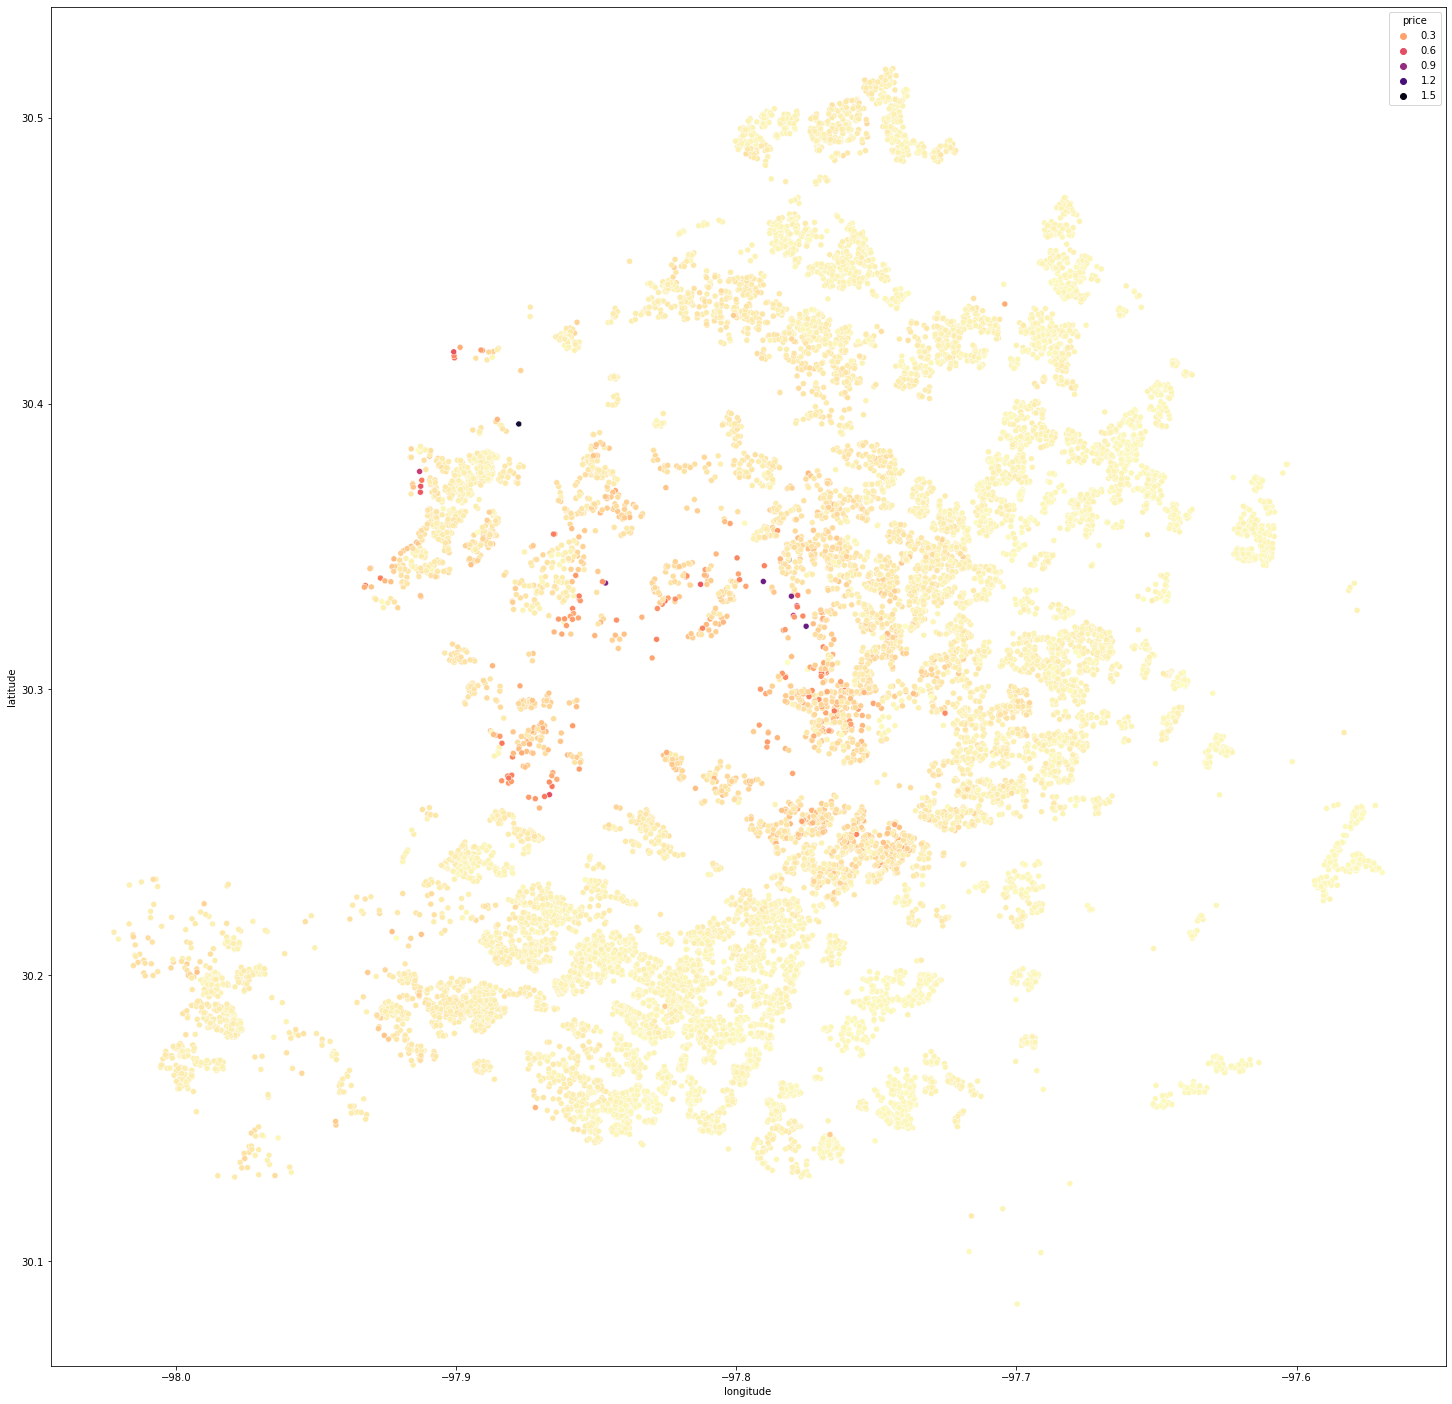

In [629]:
# plotting long and lat as a visual scatter plot to visualize outliers

plt.figure(figsize=(25,25))

sns.scatterplot(data=df, x="longitude", y="latitude", hue="price", palette="magma_r");

In [630]:
# drop latitidue below 30.15 to remove the few outliers
df.drop(df[df['latitude']<30.15].index , inplace=True)

In [631]:
# looking for outliers in the percentiles
df.describe()

price          zpid       zipcode      latitude     longitude  \
count  1.451800e+04  1.451800e+04  14518.000000  14518.000000  14518.000000   
mean   5.752363e+05  1.035585e+08  78735.862033     30.295622    -97.778147   
std    4.979448e+05  3.179184e+08     18.699228      0.095546      0.085311   
min    6.094000e+03  2.858495e+07  78617.000000     30.150009    -98.022057   
25%    3.461330e+05  2.941011e+07  78727.000000     30.207265    -97.838408   
50%    4.572370e+05  2.949184e+07  78739.000000     30.290925    -97.768970   
75%    6.410802e+05  7.033423e+07  78749.000000     30.369204    -97.716745   
max    1.555613e+07  2.146313e+09  78759.000000     30.517174    -97.569504   

       propertyTaxRate  garageSpaces  parkingSpaces     yearBuilt  \
count     14518.000000  14518.000000   14518.000000  14518.000000   
mean          1.994485      1.227786       1.227166   1988.307825   
std           0.053902      1.343260       1.343391     21.534079   
min           1.980000      0.000000       0.000000   1905.000000   
25%           1.980000      0.000000       0.000000   1974.000000   
50%           1.980000      1.000000       1.000000   1993.000000   
75%           1.980000      2.000000       2.000000   2006.000000   
max           2.210000     22.000000      22.000000   2020.000000   

         orig_price  numPriceChanges  latest_salemonth  latest_saleyear  \
count  1.451800e+04     14518.000000      14518.000000     14518.000000   
mean   5.156765e+05         3.033682          6.731024      2019.076112   
std    4.454416e+05         2.479877          3.141851         0.813661   
min    5.500000e+03         1.000000          1.000000      2018.000000   
25%    3.100000e+05         1.000000          4.000000      2018.000000   
50%    4.100000e+05         2.000000          7.000000      2019.000000   
75%    5.750000e+05         4.000000          9.000000      2020.000000   
max    1.350000e+07        23.000000         12.000000      2021.000000   

        numOfPhotos  numOfAccessibilityFeatures  numOfAppliances  \
count  14518.000000                14518.000000     14518.000000   
mean      30.785301                    0.013156         3.486913   
std       21.192085                    0.181550         1.873542   
min        1.000000                    0.000000         0.000000   
25%       20.000000                    0.000000         2.000000   
50%       29.000000                    0.000000         3.000000   
75%       39.000000                    0.000000         4.000000   
max      179.000000                    8.000000        10.000000   

       numOfParkingFeatures  numOfPatioAndPorchFeatures  \
count          14518.000000                14518.000000   
mean               1.712977                    0.667516   
std                0.782417                    0.983157   
min                0.000000                    0.000000   
25%                1.000000                    0.000000   
50%                2.000000                    0.000000   
75%                2.000000                    1.000000   
max                6.000000                    8.000000   

       numOfSecurityFeatures  numOfWaterfrontFeatures  numOfWindowFeatures  \
count           14518.000000             14518.000000         14518.000000   
mean                0.470657                 0.002686             0.209809   
std                 0.826100                 0.060363             0.490238   
min                 0.000000                 0.000000             0.000000   
25%                 0.000000                 0.000000             0.000000   
50%                 0.000000                 0.000000             0.000000   
75%                 1.000000                 0.000000             0.000000   
max                 6.000000                 2.000000             4.000000   

       numOfCommunityFeatures   lotSizeSqFt  livingAreaSqFt  \
count            14518.000000  1.451800e+04    14518.000000   
mean                 0.011641 

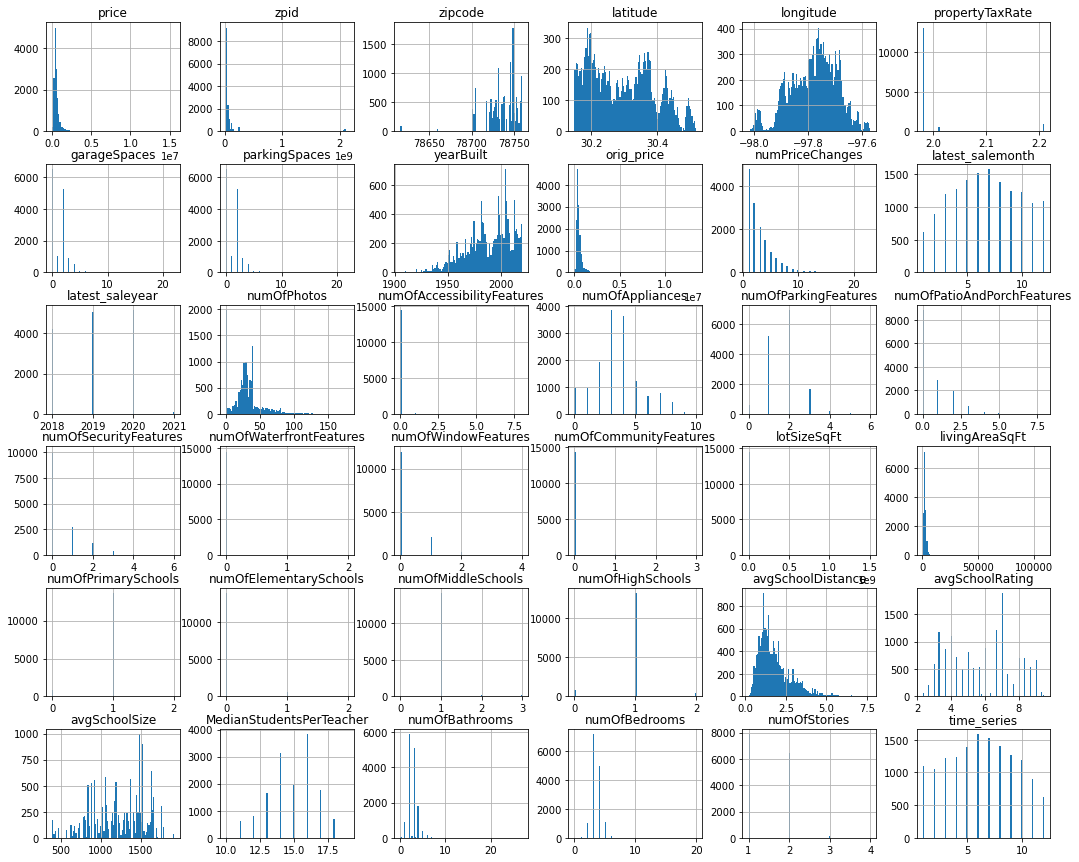

In [632]:
# use histogram for visualization of outliers
df.hist(figsize=(18,15), bins=100);

In [633]:
# verify lotSizeSqft is valid for small sqft
df.sort_values('lotSizeSqFt', ascending=False).head(10)


price       zpid    city           streetAddress  zipcode  \
14654  1941912.0   58297775  austin          3200 W 35th St    78703   
9244    190324.0   62605548  austin   706 W 22nd St APT 306    78705   
11116   208577.0  145652991  austin        4319 Nitschke St    78723   
2340    680880.0  124837778  austin     4304 Front Range Ln    78732   
4635   1038012.0  202157510  austin      201 Charismatic Pl    78737   
8071    238037.0   29552375  austin  16819 Village Oak Loop    78717   
3549    497966.0   29420734  austin         1705 Barbara St    78757   
869     686735.0  121722729  austin        14216 Tyburn Trl    78717   
1610    446386.0  119616680  austin        910 Wild Rose Dr    78737   
1703    448353.0  119622539  austin        689 Wild Rose Dr    78737   

                                             description   latitude  \
14654  Fabulous 4 Bed 4 Bath house on one of the larg...  30.314316   
9244   Leased for $1695 though 7/31/2020 - Unique gat...  30.285631   
11116  **Subject to City of Austin SMART Housing and ...  30.294910   
2340   4304 Front Range Ln, Austin, TX 78732 is a sin...  30.380476   
4635   201 Charismatic Pl, Austin, TX 78737 is a sing...  30.205276   
8071   Newly remodeled 3-2 conveniently located in Br...  30.509415   
3549   Don't miss out on this central Austin gem. Rar...  30.350731   
869    Rare 2 story home with 5 bed, 4.5 bath, dedica...  30.490353   
1610   Gorgeous and very meticulously maintained 1 st...  30.167274   
1703   This beautiful one-story home features warm ca...  30.168011   

       longitude  propertyTaxRate  garageSpaces  hasAssociation  hasCooling  \
14654 -97.768044             1.98             5           False        True   
9244  -97.745697             1.98             0            True        True   
11116 -97.698997             1.98             1            True        True   
2340  -97.881027             1.98             2            True        True   
4635  -98.011406             2.01             3            True        True   
8071  -97.740211             2.21             2            True        True   
3549  -97.724510             1.98             1           False        True   
869   -97.789581             2.21             2            True        True   
1610  -97.985947             2.01             0            True        True   
1703  -97.983322             2.01             2            True        True   

       hasGarage  hasHeating  hasSpa  hasView       homeType  parkingSpaces  \
14654       True        True   False    False  Single Family              5   
9244       False        True   False    False          Condo              0   
11116       True        True   False    False      Townhouse              1   
2340        True        True   False     True  Single Family              2   
4635        True        True    True    False  Single Family              3   
8071        True        True   False     True  Single Family              2   
3549        True        True   False    False  Single Family              1   
869         True        True   False     True  Single Family              2   
1610       False        True   False    False  Single Family              0   
1703        True        True   False     True  Single Family              2   

       yearBuilt  orig_price  numPriceChanges latest_saledate  \
14654       1955   1650000.0                3      2020-02-20   
9244        1982    179900.0                7      2019-10-15   
11116       2016    187471.0                1      2020-06-29   
2340        2014    569000.0                1      2019-03-29   
4635        2015    999500.0                3      2019-11-08   
8071        1985    225000.0                4      2019-10-24   
3549        1959    435000.0                1      2020-04-08   
869         2015    599900.0                1      2020-04-15   
1610        2014    379900.0                1      2018-05-24   
1703        2013    439900.0                2 

In [634]:
# drop lotsize due to condos and townhomes
df.drop("lotSizeSqFt", axis=1, inplace=True)

In [635]:
# verifty livingAreaSqFt is valid for small sqft
df.sort_values('livingAreaSqFt', ascending=True).head(10)

price       zpid    city                streetAddress  zipcode  \
1170   960658.0   94641643  austin       3003 Brass Buttons Trl    78734   
3518   155233.0   29420819  austin              404 Primrose St    78753   
13314  185140.0   29330022  austin     1405 Hartford Rd APT 202    78703   
9213   164541.0  145658912  austin       1011 W 23rd St APT 103    78705   
10118  527915.0   29385318  austin               2202 E 10th St    78702   
10698  260098.0  241938554  austin       3110 Congress Ave #303    78704   
10230  199958.0   29385449  austin         804 Northwestern Ave    78702   
9482   405259.0   29382530  austin                1214 Holly St    78702   
9338   417888.0   29382261  austin            1806 Riverview St    78702   
13868  208537.0   80087107  austin  2021 Bluebonnet Ln UNIT 101    78704   

                                             description   latitude  \
1170   Lake Austin Waterfront lot in Apache Shores! O...  30.381195   
3518   404 Primrose St, Austin, TX 78753 is a single ...  30.350330   
13314  Old West Austin Efficiency. Close to metro/UT ...  30.284014   
9213   Very desirable location for UT students only 5...  30.287077   
10118  Great opportunity to build on your lot in high...  30.264668   
10698  Fab SoCo studio condo, just a few yrs old, tur...  30.231682   
10230  Boho-modern tiny house in fantastic location! ...  30.264870   
9482   Excellent build/remodel opportunity in Holly D...  30.256088   
9338   Property is currently occupied by tenant who i...  30.252127   
13868  Minimalist condo with clever upgrades througho...  30.251099   

       longitude  propertyTaxRate  garageSpaces  hasAssociation  hasCooling  \
1170  -97.915985             1.98             0            True        True   
3518  -97.697739             1.98             0           False       False   
13314 -97.762421             1.98             0            True        True   
9213  -97.748085             1.98             1            True        True   
10118 -97.717590             1.98             2            True        True   
10698 -97.758957             1.98             0            True        True   
10230 -97.713547             1.98             0           False        True   
9482  -97.733093             1.98             0           False        True   
9338  -97.727493             1.98             0           False       False   
13868 -97.773987             1.98             0            True        True   

       hasGarage  hasHeating  hasSpa  hasView       homeType  parkingSpaces  \
1170       False        True   False    False  Single Family              0   
3518       False       False   False    False  Single Family              0   
13314      False        True   False    False          Condo              0   
9213        True        True   False     True          Condo              1   
10118       True        True   False     True          Condo              2   
10698      False        True   False     True          Condo              0   
10230      False        True   False    False  Single Family              0   
9482       False        True   False    False  Single Family              0   
9338       False        True   False    False  Single Family              0   
13868      False        True   False     True          Condo              0   

       yearBuilt  orig_price  numPriceChanges latest_saledate  \
1170        2012    850000.0                4      2018-07-21   
3518        1945    139000.0                1      2019-07-02   
13314       1972    175000.0                1      2019-10-01   
9213        1972    151500.0                5      2018-09-29   
10118       2019    499000.0                4      2019-10-22   
10698       2016    224900.0                1      2019-05-06   
10230       1946    169900.0                6      2020-02-18   
9482        1932    319900.0                1      2018-01-23   
9338        1928    395000.0                1      2019-10-16   
1

In [636]:
# verifty livingAreaSqFt is valid for large sqft
df.sort_values('livingAreaSqFt', ascending=False).head(10)

price       zpid    city            streetAddress  zipcode  \
705     401434.0   70330356  austin            201 Marly Way    78733   
2557   1011842.0   64523076  austin           9704 Saugus Ln    78733   
2316  14076258.0  125904370  austin           12400 Cedar St    78732   
5328   3172530.0   29327226  austin     3509 Lost Creek Blvd    78735   
375    5484816.0   89551873  austin  14800 Flat Top Ranch Rd    78732   
4753   2402590.0   29328861  austin         7702 Sandia Loop    78735   
1360   7294404.0   70337612  austin  14300 Flat Top Ranch Rd    78732   
2547   3344568.0  119986580  austin            305 Marly Way    78733   
613    3231280.0   96645484  austin        9113 Camelback Dr    78733   
4882   5919707.0   70330275  austin          4429 Mirador Dr    78735   

                                            description   latitude  longitude  \
705   Level building site with great canyon views an...  30.323517 -97.861473   
2557  New Construction, EANES Schools, 4bed 3 bath, ...  30.345898 -97.859985   
2316  12400 Cedar Street - Villa Del Lago is a uniqu...  30.392859 -97.877609   
5328  *$6,762,377 is Tax Value - Set in exclusive Ba...  30.272158 -97.856033   
375   GRACIOUS LUXURY ON LAKE AUSTIN\r\nThis award-w...  30.368996 -97.912720   
4753  Perfectly poised on 4.5+ acres in the highly r...  30.277086 -97.860168   
1360  Huge Price Improvement. Prized waterfront retr...  30.376249 -97.913002   
2547  Open floor plan with ample light.  Unbelievabl...  30.324699 -97.861267   
613   Sweeping views abound from this 10,802-square-...  30.331038 -97.855659   
4882  Stunning home in Mirador on over 10 acres.  Th...  30.263178 -97.866661   

      propertyTaxRate  garageSpaces  hasAssociation  hasCooling  hasGarage  \
705              1.98             0            True        True      False   
2557             1.98             0            True        True      False   
2316             1.98             5           False        True       True   
5328             1.98             7            True        True       True   
375              1.98             6            True        True       True   
4753             1.98             5            True        True       True   
1360             1.98             0            True        True      False   
2547             1.98             4            True        True       True   
613              1.98             3            True        True       True   
4882             1.98             7            True        True       True   

      hasHeating  hasSpa  hasView       homeType  parkingSpaces  yearBuilt  \
705         True   False    False  Single Family              0       2012   
2557        True   False    False  Single Family              0       2018   
2316        True   False     True  Single Family              5       2016   
5328        True    True    False  Single Family              7       2003   
375         True    True     True  Single Family              6       2014   
4753        True    True    False  Single Family              5       1999   
1360        True    True     True  Single Family              0       2006   
2547        True    True     True  Single Family              4       2014   
613         True   False    False  Single Family              3       2007   
4882        True    True     True  Single Family              7       2006   

      orig_price  numPriceChanges latest_saledate  latest_salemonth  \
705     385000.0                2      2018-11-12                11   
2557    829000.0                1      2018-03-08                 3   
2316  13500000.0                2      2018-11-28                11   
5328   2700000.0                4      2018-05-20                 5   
375    4950000.0                6      2018-08-17                 8   
4753   2190000.0               13      2019-08-15                 8   
1360   6200000.0                5      2019-04-30                 4   
2547   2795000.0             

In [637]:
# Removing row 705 and 2557 as their size is outside reasonability or probablility compared to rest of dataset
df.drop(index=[705, 2557], inplace=True)

In [638]:
# look for outlier on descending
df.sort_values('numOfBathrooms', ascending=False).head(10)

price       zpid    city            streetAddress  zipcode  \
2838    780946.0  111972888  austin       4212 Far West Blvd    78731   
2316  14076258.0  125904370  austin           12400 Cedar St    78732   
613    3231280.0   96645484  austin        9113 Camelback Dr    78733   
5328   3172530.0   29327226  austin     3509 Lost Creek Blvd    78735   
2547   3344568.0  119986580  austin            305 Marly Way    78733   
375    5484816.0   89551873  austin  14800 Flat Top Ranch Rd    78732   
184    4165941.0  124843021  austin        13115 Perryton Dr    78732   
4753   2402590.0   29328861  austin         7702 Sandia Loop    78735   
4920   3438565.0   58297259  austin          4800 Mirador Dr    78735   
1360   7294404.0   70337612  austin  14300 Flat Top Ranch Rd    78732   

                                            description   latitude  longitude  \
2838  Well-maintained home in highly desirable North...  30.361406 -97.769707   
2316  12400 Cedar Street - Villa Del Lago is a uniqu...  30.392859 -97.877609   
613   Sweeping views abound from this 10,802-square-...  30.331038 -97.855659   
5328  *$6,762,377 is Tax Value - Set in exclusive Ba...  30.272158 -97.856033   
2547  Open floor plan with ample light.  Unbelievabl...  30.324699 -97.861267   
375   GRACIOUS LUXURY ON LAKE AUSTIN\r\nThis award-w...  30.368996 -97.912720   
184   This highly custom home sits on a well-establi...  30.338959 -97.926979   
4753  Perfectly poised on 4.5+ acres in the highly r...  30.277086 -97.860168   
4920  You must experience the intimacy of this beaut...  30.261778 -97.871712   
1360  Huge Price Improvement. Prized waterfront retr...  30.376249 -97.913002   

      propertyTaxRate  garageSpaces  hasAssociation  hasCooling  hasGarage  \
2838             1.98             2           False        True       True   
2316             1.98             5           False        True       True   
613              1.98             3            True        True       True   
5328             1.98             7            True        True       True   
2547             1.98             4            True        True       True   
375              1.98             6            True        True       True   
184              1.98             4            True        True       True   
4753             1.98             5            True        True       True   
4920             1.98             4            True        True       True   
1360             1.98             0            True        True      False   

      hasHeating  hasSpa  hasView       homeType  parkingSpaces  yearBuilt  \
2838        True   False    False  Single Family              2       1967   
2316        True   False     True  Single Family              5       2016   
613         True   False    False  Single Family              3       2007   
5328        True    True    False  Single Family              7       2003   
2547        True    True     True  Single Family              4       2014   
375         True    True     True  Single Family              6       2014   
184         True    True     True  Single Family              4       2014   
4753        True    True    False  Single Family              5       1999   
4920        True   False    False  Single Family              4       2002   
1360        True    True     True  Single Family              0       2006   

      orig_price  numPriceChanges latest_saledate  latest_salemonth  \
2838    745000.0                1      2020-10-20                10   
2316  13500000.0                2      2018-11-28                11   
613    2750000.0                7      2018-05-02                 5   
5328   2700000.0                4      2018-05-20                 5   
2547   2795000.0                7      2019-03-07                 3   
375    4950000.0                6      2018-08-17                 8   
184    4100000.0                3      2020-12-23                12   
4753   2190000.0             

In [639]:
# Change number of bathrooms to a more realistic number of 2.5 versus 27 instead of dropping
df.loc[df.index==2838, 'numOfBathrooms'] = 2.5

In [640]:
# look for outliers on ascending
df.sort_values('numOfBathrooms', ascending=True).head(10)

price       zpid    city         streetAddress  zipcode  \
6646    493682.0   29503854  austin     8604 Oak Ledge Dr    78748   
4464    449455.0   63596867  austin      200 Lexington Dr    78737   
7049    372604.0   29490118  austin      6800 Manchaca Rd    78745   
14357   890066.0   29335803  austin        2709 Townes Ln    78703   
6252   1010014.0   29327134  austin     2005 Real Catorce    78746   
12316   402080.0   29491384  austin     5809 Marchmont Ln    78749   
14716  1890905.0   29397153  austin       1106 Claire Ave    78703   
12003   388375.0  119616859  austin        10809 Dinah Dr    78748   
1842    995762.0   94642666  austin  10640 Senna Hills Dr    78733   
13848   878075.0   29473280  austin         2204 S 3rd St    78704   

                                             description   latitude  \
6646   8604 Oak Ledge Dr, Austin, TX 78748 is a singl...  30.188589   
4464   200 Lexington Dr, Austin, TX 78737 is a single...  30.199942   
7049   The gated community of SoMa Village is located...  30.204607   
14357  Remodeled Tarry Town Jewel, Grand entry highli...  30.298880   
6252   2005 Real Catorce, Austin, TX 78746 is a singl...  30.269354   
12316  5809 Marchmont Ln, Austin, TX 78749 is a singl...  30.210625   
14716  1106 Claire Ave, Austin, TX 78703 is a single ...  30.294628   
12003  10809 Dinah Dr, Austin, TX 78748 is a single f...  30.164707   
1842   Wow! Reduced! First time on the market! Move i...  30.312716   
13848  Rare sized large lot in Bouldin sold alone or ...  30.245035   

       longitude  propertyTaxRate  garageSpaces  hasAssociation  hasCooling  \
6646  -97.823662             1.98             0           False        True   
4464  -97.984703             2.01             0            True        True   
7049  -97.808357             1.98             2           False       False   
14357 -97.767937             1.98             2           False        True   
6252  -97.818771             1.98             0            True        True   
12316 -97.871208             1.98             0            True        True   
14716 -97.749329             1.98             0           False        True   
12003 -97.834358             1.98             2            True        True   
1842  -97.900482             1.98             2            True        True   
13848 -97.761261             1.98             3           False        True   

       hasGarage  hasHeating  hasSpa  hasView       homeType  parkingSpaces  \
6646       False        True   False    False  Single Family              0   
4464       False        True   False    False  Single Family              0   
7049        True        True   False    False  Single Family              2   
14357       True        True   False     True  Single Family              2   
6252       False        True   False    False  Single Family              0   
12316      False        True   False     True  Single Family              0   
14716      False        True   False     True  Single Family              0   
12003       True        True   False     True  Single Family              2   
1842        True        True   False     True  Single Family              2   
13848       True        True   False    False  Single Family              3   

       yearBuilt  orig_price  numPriceChanges latest_saledate  \
6646        1971    450000.0                1      2019-08-07   
4464        2004    409900.0                2      2020-07-06   
7049        2017    334900.0                1      2020-06-12   
14357       1953    800000.0               12      2020-06-29   
6252        1999    949000.0                4      2018-10-30   
12316       1997    394500.0                3      2019-12-30   
14716       1938   1585000.0                4      2020-01-09   
12003       2013    364900.0                1      2020-09-01   
1842        2011    895000.0                5      2020-06-24   
13848       1947    825000.0                4      2020-09-11   

  

In [641]:
# various data shows 0 bathrooms with some amount of bedrooms, and some show 0 bathrooms and 0 bedrooms.  to help alleviate losing other data for ml, replace 0 bathrooms with arbritary amounts between 1 and two along with bedrooms
df.loc[(df['numOfBathrooms']==0) & (df['numOfBedrooms']>0) & (df['yearBuilt'] > 1989), 'numOfBathrooms'] = 2
df.loc[(df['numOfBathrooms']==0) & (df['numOfBedrooms']>0) & (df['yearBuilt'] <= 1989), 'numOfBathrooms'] = 1
df.loc[(df['numOfBathrooms']==0) & (df['numOfBedrooms']>=3) & (df['yearBuilt'] > 1989), 'numOfBathrooms'] = 2.5
df.loc[(df['numOfBathrooms']==0) & (df['numOfBedrooms']>=3) & (df['yearBuilt'] <= 1989), 'numOfBathrooms'] = 2

df.drop(df[df['numOfBathrooms']==0].index, inplace=True)
df.drop(df[df['numOfBedrooms']==0].index, inplace=True)

In [642]:
# look at bedrooms descending
df.sort_values('numOfBedrooms', ascending=False).head(5)

price        zpid    city         streetAddress  zipcode  \
8597    180525.0  2094498207  austin  4902 Duval Rd R2 #R2    78727   
8531    702270.0    58306332  austin     3906 Hawkshead Dr    78727   
2531   1225505.0    64616594  austin       9613 Tavares Cv    78733   
14435   898270.0    29401385  austin   4302 Avenue G APT C    78751   
80      405156.0   241932936  austin   5217 Bonneville Bnd    78744   

                                             description   latitude  \
8597   Lovely convenient condo, with a private wooded...  30.415489   
8531   Enjoy this home across from The Domain! Comple...  30.416149   
2531   This spacious home boasts nearly 7000 square f...  30.347956   
14435  Charming 3-unit multifamily property built by ...  30.305981   
80     This home is ready for you - Updated with hard...  30.178495   

       longitude  propertyTaxRate  garageSpaces  hasAssociation  hasCooling  \
8597  -97.737213             1.98             0            True        True   
8531  -97.722801             1.98             2           False        True   
2531  -97.856590             1.98             0            True        True   
14435 -97.728012             1.98             0           False       False   
80    -97.696663             1.98             2            True        True   

       hasGarage  hasHeating  hasSpa  hasView       homeType  parkingSpaces  \
8597       False        True   False     True          Condo              0   
8531        True        True   False    False  Single Family              2   
2531       False        True   False     True  Single Family              0   
14435      False        True   False    False  Single Family              0   
80          True        True   False    False  Single Family              2   

       yearBuilt  orig_price  numPriceChanges latest_saledate  \
8597        1985    174900.0                2      2020-11-13   
8531        2006    650000.0                1      2020-08-05   
2531        2004   1200000.0                7      2018-12-05   
14435       1925    750000.0                1      2018-04-27   
80          2016    375000.0                2      2020-08-31   

       latest_salemonth  latest_saleyear latestPriceSource  numOfPhotos  \
8597                 11             2020    Agent Provided           25   
8531                  8             2020    Agent Provided           36   
2531                 12             2018    Agent Provided           40   
14435                 4             2018    Agent Provided           15   
80                    8             2020    Agent Provided           78   

       numOfAccessibilityFeatures  numOfAppliances  numOfParkingFeatures  \
8597                            0                4                     1   
8531                            0                2                     2   
2531                            0                2                     1   
14435                           0                0                     1   
80                              0                2                     2   

       numOfPatioAndPorchFeatures  numOfSecurityFeatures  \
8597                            0                      0   
8531                            2                      3   
2531                            0                      0   
14435                           0                      0   
80                              1                      0   

       numOfWaterfrontFeatures  numOfWindowFeatures  numOfCommunityFeatures  \
8597                         0                    0                       0   
8531                         0                    1                       0   
2531                         0                    0                       0   
14435                        0                    0                       0   
80                           0                    0                       0   

       livingAreaSqFt  numOfPrimarySchools  numOfElementarySchools  \
85

In [643]:
# row 8597 can't support 20 bedrooms, change to common 2
df.loc[df.index==8597, 'numOfBedrooms'] = 2

In [644]:
# check garage spaces
df.sort_values('garageSpaces', ascending=False).head(10)

price       zpid    city             streetAddress  zipcode  \
6885    411834.0  145656156  austin       705 Mc Queen St #34    78745   
4533   1006838.0   28587235  austin  13100 Rooster Springs Rd    78737   
6805    575963.0   29502805  austin        7600 Elm Forest Rd    78745   
9240   3892150.0   29396074  austin              908 Keith Ln    78705   
6985    333275.0   29494837  austin        6907 Cherrydale Dr    78745   
11108   516083.0   29409917  austin         1405 Berkshire Dr    78723   
4777   1620652.0   29331364  austin    3301 Barton Creek Blvd    78735   
15164  1571326.0  125807167  austin               8707 Leo St    78745   
3459    533443.0   29423855  austin          8909 Georgian Dr    78753   
9201    293405.0   29445509  austin              13712 Ann Pl    78728   

                                             description   latitude  \
6885   Beautiful 2-story home located in highly sough...  30.189331   
4533   Enjoy country living with the convenience of t...  30.204746   
6805   Gorgeous 3/2 home owner remodel on almost 2/3 ...  30.190971   
9240   Keith Lane is has our homes strategically plac...  30.291706   
6985   Beautifully remodeled home in HOT 78745!! This...  30.200857   
11108  Beautifully renovated single story mid-century...  30.317060   
4777   Privately gated Barton Creek estate on 1.58 Ac...  30.283585   
15164  Brand new construction.  High end home that si...  30.189131   
3459   Unique opportunity to own a large lot in an ar...  30.356129   
9201   13712 Ann Pl, Austin, TX 78728 is a single fam...  30.427391   

       longitude  propertyTaxRate  garageSpaces  hasAssociation  hasCooling  \
6885  -97.792809             1.98            22            True        True   
4533  -97.991356             2.01            20           False        True   
6805  -97.800804             1.98            12           False        True   
9240  -97.725502             1.98            12           False        True   
6985  -97.803902             1.98            12           False        True   
11108 -97.697220             1.98            12           False        True   
4777  -97.875526             1.98            12            True        True   
15164 -97.825455             1.98            10           False        True   
3459  -97.695686             1.98            10           False        True   
9201  -97.675156             1.98            10           False        True   

       hasGarage  hasHeating  hasSpa  hasView       homeType  parkingSpaces  \
6885        True        True   False     True          Condo             22   
4533        True        True   False     True  Single Family             20   
6805        True        True   False    False  Single Family             12   
9240        True        True   False    False  Single Family             12   
6985        True        True   False     True  Single Family             12   
11108       True        True   False     True  Single Family             12   
4777        True        True    True    False  Single Family             12   
15164       True        True    True    False  Single Family             10   
3459        True        True    True    False  Single Family             10   
9201        True        True   False    False  Single Family             10   

       yearBuilt  orig_price  numPriceChanges latest_saledate  \
6885        2016    399000.0                1      2020-11-15   
4533        2018    824900.0                2      2018-03-08   
6805        1960    525000.0                7      2019-08-19   
9240        2003   3400000.0                1      2020-04-01   
6985        1972    328000.0                3      2020-12-28   
11108       1955    500000.0                2      2020-11-10   
4777        1991   1595000.0               15      2020-12-04   
15164       2020   1499000.0                5      2020-10-23   
3459        1949    525000.0                4      2020-12-31   
9201        1979    2799

In [645]:
# garage spaces similar to bathrooms and bedrooms needs to have a conversion
df.loc[(df['garageSpaces'] > 3) & (df['price'] < 1000000) & (df['homeType'] == 'Single Family'), 'garageSpaces'] = 3
df.loc[(df['garageSpaces'] > 5) & (df['price'] > 1000000)& (df['homeType'] == 'Single Family'), 'garageSpaces'] = 4
df.loc[df.index==6885, 'garageSpaces'] = 2

In [646]:
# verifty parking spaces
df.sort_values('parkingSpaces', ascending=False).head(5)

price       zpid    city             streetAddress  zipcode  \
6885   411834.0  145656156  austin       705 Mc Queen St #34    78745   
4533  1006838.0   28587235  austin  13100 Rooster Springs Rd    78737   
6805   575963.0   29502805  austin        7600 Elm Forest Rd    78745   
9240  3892150.0   29396074  austin              908 Keith Ln    78705   
6985   333275.0   29494837  austin        6907 Cherrydale Dr    78745   

                                            description   latitude  longitude  \
6885  Beautiful 2-story home located in highly sough...  30.189331 -97.792809   
4533  Enjoy country living with the convenience of t...  30.204746 -97.991356   
6805  Gorgeous 3/2 home owner remodel on almost 2/3 ...  30.190971 -97.800804   
9240  Keith Lane is has our homes strategically plac...  30.291706 -97.725502   
6985  Beautifully remodeled home in HOT 78745!! This...  30.200857 -97.803902   

      propertyTaxRate  garageSpaces  hasAssociation  hasCooling  hasGarage  \
6885             1.98             2            True        True       True   
4533             2.01             4           False        True       True   
6805             1.98             3           False        True       True   
9240             1.98             4           False        True       True   
6985             1.98             3           False        True       True   

      hasHeating  hasSpa  hasView       homeType  parkingSpaces  yearBuilt  \
6885        True   False     True          Condo             22       2016   
4533        True   False     True  Single Family             20       2018   
6805        True   False    False  Single Family             12       1960   
9240        True   False    False  Single Family             12       2003   
6985        True   False     True  Single Family             12       1972   

      orig_price  numPriceChanges latest_saledate  latest_salemonth  \
6885    399000.0                1      2020-11-15                11   
4533    824900.0                2      2018-03-08                 3   
6805    525000.0                7      2019-08-19                 8   
9240   3400000.0                1      2020-04-01                 4   
6985    328000.0                3      2020-12-28                12   

      latest_saleyear latestPriceSource  numOfPhotos  \
6885             2020    Agent Provided           30   
4533             2018    Agent Provided            3   
6805             2019    Agent Provided           33   
9240             2020    Agent Provided           20   
6985             2020    Agent Provided           46   

      numOfAccessibilityFeatures  numOfAppliances  numOfParkingFeatures  \
6885                           0                2                     2   
4533                           0                7                     3   
6805                           0                8                     1   
9240                           0                5                     4   
6985                           0                4                     2   

      numOfPatioAndPorchFeatures  numOfSecurityFeatures  \
6885                           3                      0   
4533                           0                      0   
6805                           2                      2   
9240                           0                      0   
6985                           1                      0   

      numOfWaterfrontFeatures  numOfWindowFeatures  numOfCommunityFeatures  \
6885                        0                    0                       0   
4533                        0                    0                       0   
6805                        0                    2                       0   
9240                        0                    0                       0   
6985                        0                    0                       0   

      livingAreaSqFt  numOfPrimarySchools  numOfElementarySchools  \
6885          2080.0                  

In [647]:
# another change in data
df.loc[(df['parkingSpaces'] > 3) & (df['price'] < 1000000 & (df['homeType'] == 'Single Family')), 'parkingSpaces'] = 3
df.loc[(df['parkingSpaces'] > 5) & (df['price'] > 1000000& (df['homeType'] == 'Single Family')), 'parkingSpaces'] = 5
df.loc[df.index==6885, 'parkingSpaces'] = 2

df.sort_values('parkingSpaces', ascending=False).head(5)


price       zpid    city          streetAddress  zipcode  \
3740   759876.0   29443959  austin        12426 Deer Trak    78727   
2308   567691.0   60134388  austin  3213 Summer Canyon Dr    78732   
4488   499379.0  114157307  austin           459 Drury Ln    78737   
2323  1891280.0   64518113  austin     10600 Merrywing Cv    78730   
2320  2133775.0   94641625  austin  5833 River Place Blvd    78730   

                                            description   latitude  longitude  \
3740  UNDER OPTION! The "MODERN FARMHOUSE" Perfected...  30.426296 -97.732033   
2308  Looking for peace and quiet in Steiner Ranch? ...  30.379335 -97.904716   
4488  Immaculate home with hill country views! Locat...  30.202127 -97.970329   
2323  NEW PRICE!  Santa Barbara style estate tucked ...  30.381756 -97.850983   
2320  Gated estate home with extreme privacy and coz...  30.385012 -97.850166   

      propertyTaxRate  garageSpaces  hasAssociation  hasCooling  hasGarage  \
3740             1.98             3           False        True       True   
2308             1.98             3            True        True       True   
4488             2.01             3            True        True       True   
2323             1.98             5            True        True       True   
2320             1.98             5            True        True       True   

      hasHeating  hasSpa  hasView       homeType  parkingSpaces  yearBuilt  \
3740        True    True     True  Single Family              5       1972   
2308        True    True     True  Single Family              5       2002   
4488        True   False     True  Single Family              5       2010   
2323        True    True    False  Single Family              5       2003   
2320        True    True     True  Single Family              5       2008   

      orig_price  numPriceChanges latest_saledate  latest_salemonth  \
3740    724900.0                4      2020-10-06                10   
2308    550000.0                1      2020-11-25                11   
4488    425000.0                7      2018-05-16                 5   
2323   1699900.0                6      2020-06-12                 6   
2320   2100000.0                1      2020-12-28                12   

      latest_saleyear             latestPriceSource  numOfPhotos  \
3740             2020  Texas Ally Real Estate Group           79   
2308             2020                Agent Provided           29   
4488             2018                Agent Provided           42   
2323             2020                Agent Provided           40   
2320             2020                Agent Provided           87   

      numOfAccessibilityFeatures  numOfAppliances  numOfParkingFeatures  \
3740                           1                5                     2   
2308                           0                3                     2   
4488                           0                8                     2   
2323                           0                2                     2   
2320                           0                5                     2   

      numOfPatioAndPorchFeatures  numOfSecurityFeatures  \
3740                           4                      4   
2308                           1                      2   
4488                           0                      0   
2323                           2                      2   
2320                           2                      1   

      numOfWaterfrontFeatures  numOfWindowFeatures  numOfCommunityFeatures  \
3740                        0                    0                       0   
2308                        0                    0                       0   
4488                        0                    0                       1   
2323                        0                    1                       0   
2320                        0                    0                       0   

      livingAreaSqFt  numOfPrimarySchools  numOfEleme

In [648]:
# look and counts of data for the city area
df['city'].value_counts()

austin              14371
del valle              85
pflugerville           36
manor                   5
dripping springs        4
west lake hills         2
road                    1
Name: city, dtype: int64

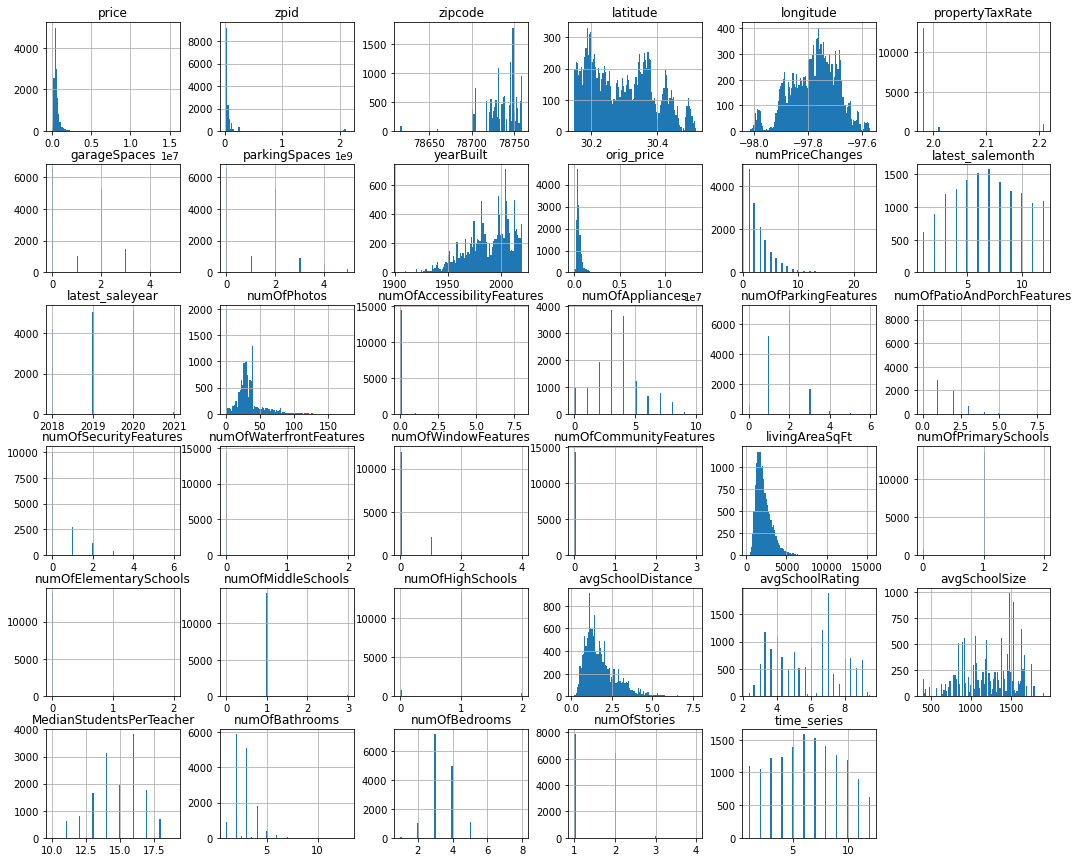

In [649]:
# use histograms to revisualize outliers
df.hist(figsize=(18,15), bins=100);

In [650]:
# Utilize IQR to further help eliminate outliers - high priced homes are underrepresented especially in parking and garage spaces
def iqr_outliers(column):
    """return the lower range and upper range for the data based on IQR*1.6"""
    Q1,Q3 = np.percentile(column , [25,75])
    iqr = Q3 - Q1
    lower_range = Q1 - (1.6 * iqr)
    upper_range = Q3 + (1.6 * iqr)
    return lower_range,upper_range  

In [651]:
# IQR based on living area
sqftlower, sqftupper = iqr_outliers(df.livingAreaSqFt)

In [652]:
# drop items outside of lower and upper range
df.drop(df[ (df.livingAreaSqFt > sqftupper) | (df.livingAreaSqFt < sqftlower) ].index , inplace=True)

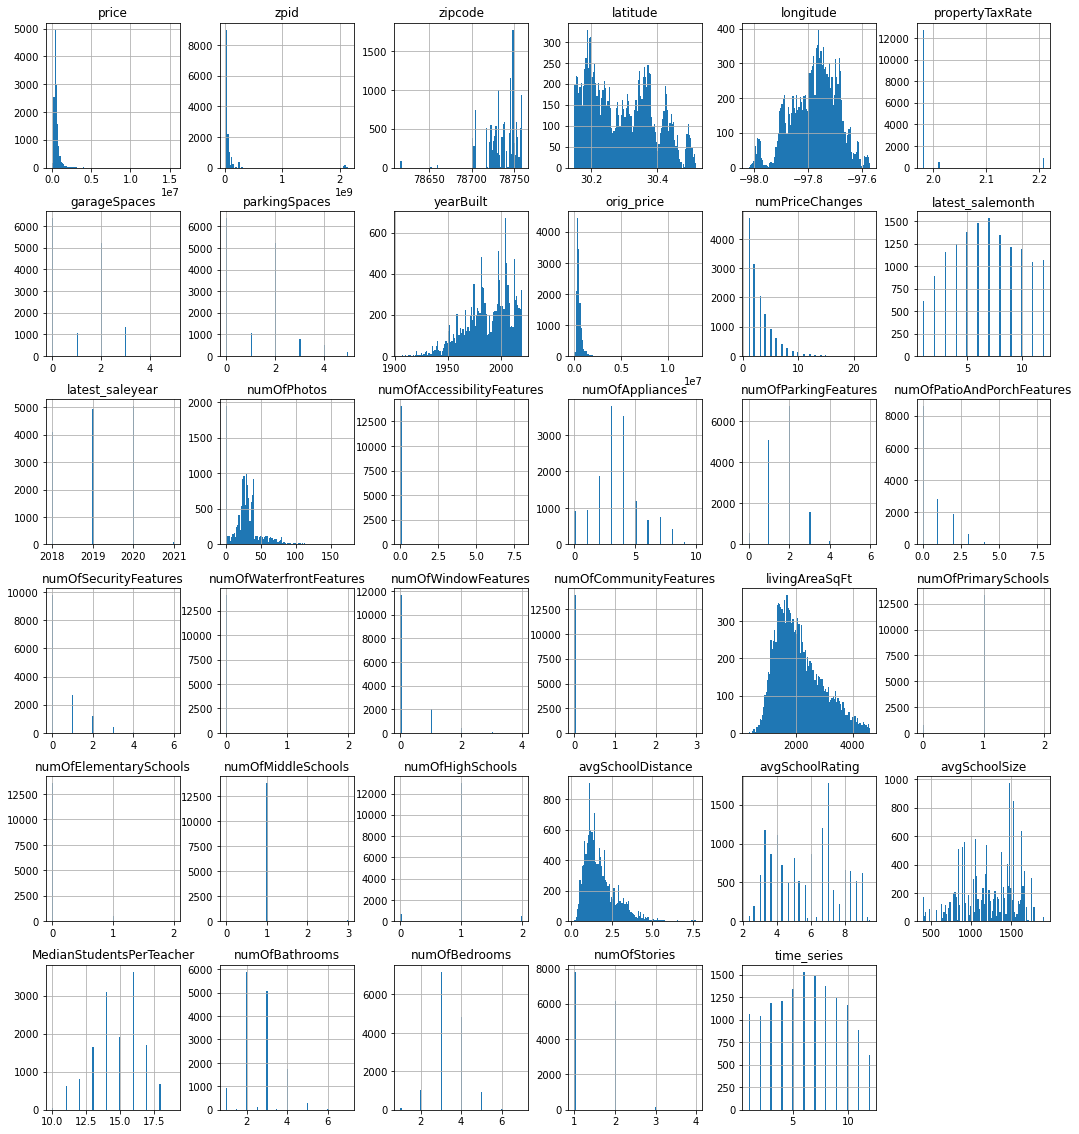

In [653]:
# verify histogram
df.hist(figsize=(18,20), bins=100);

In [654]:
#visualize items by zipcode

# group our dataframe by zipcode on median home price, sorted ascending. 
zipsorted = pd.DataFrame(df.groupby('zipcode')['price'].median().sort_values(ascending=True))

# divide our dataframe into groups with entries per group as specified above,
# and assign this number to a new column
zipsorted['rank'] = np.divmod(np.arange(len(zipsorted)), 1)[0]+1

# function that looks up a segment that a data entry belongs to
def make_group(x, frame, column):
    y = frame.loc[(frame.index == x)][column]
    z = np.array(y)
    z[0]
    return z[0]

# make a new column on our dataframe. Look up each zip entry's group, and append to the column.
df['zip_rank'] = df['zipcode'].apply(lambda x: make_group(x, zipsorted, 'rank'))

# apply the median home price per zip code to the data frame
df['median_zip'] = df['zipcode'].apply(lambda x: round(df.loc[df['zipcode']==x]['price'].median(), 0))

''

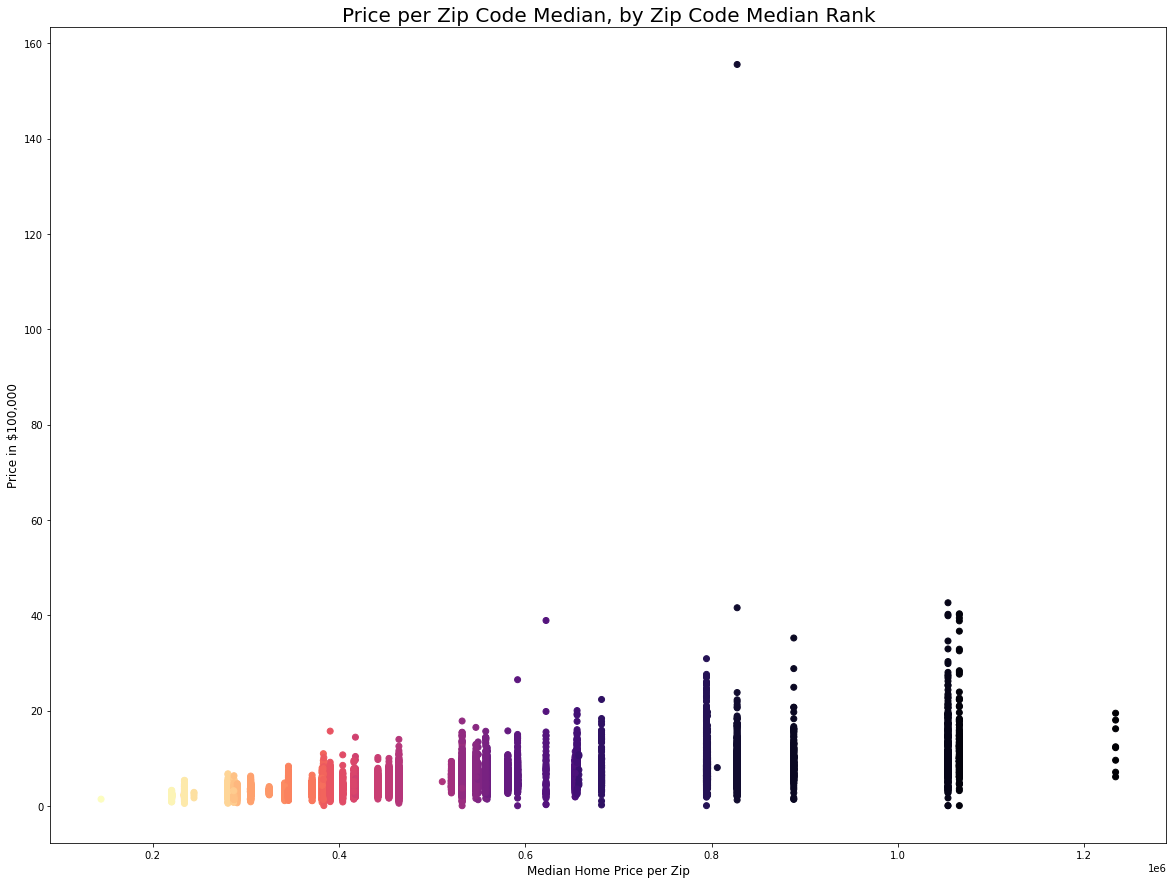

In [655]:
# visualize zip code as a color function

fig, ax = plt.subplots(figsize=(20, 15))

ax.scatter(df['median_zip'], df['price'] /100000, c=df['zip_rank'], cmap='magma_r')

ax.set_xlabel('Median Home Price per Zip', fontsize=12)
ax.set_ylabel('Price in $100,000', fontsize=12)
ax.set_title('Price per Zip Code Median, by Zip Code Median Rank', fontsize=20)
;

Text(0.5, 1.0, 'Price per Total Square Feet, by Zip Code Median Rank')

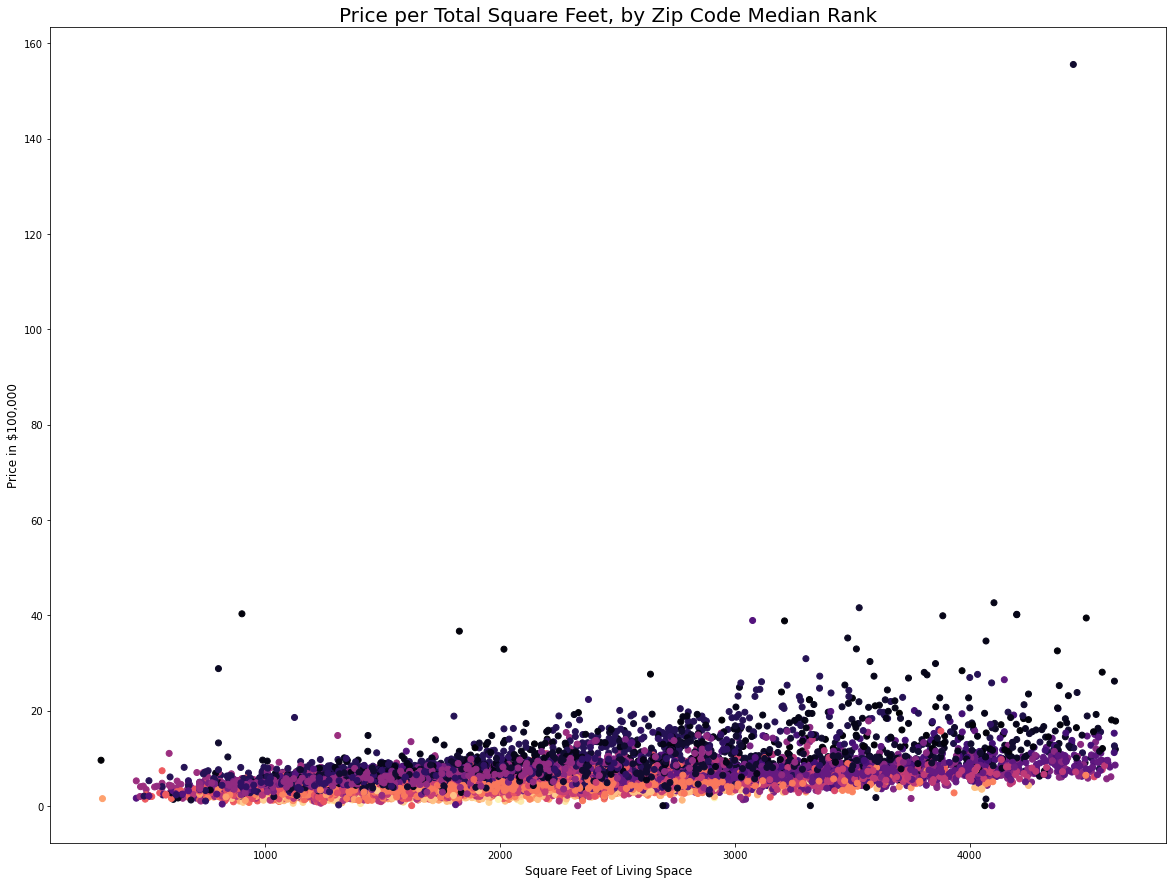

In [656]:
# visualize zip code as a color function, on a plot of price per square footage

fig, ax = plt.subplots(figsize=(20, 15))

ax.scatter(df['livingAreaSqFt'], df['price'] /100000, c=df['zip_rank'], cmap='magma_r')

ax.set_xlabel('Square Feet of Living Space', fontsize=12)
ax.set_ylabel('Price in $100,000', fontsize=12)
ax.set_title('Price per Total Square Feet, by Zip Code Median Rank', fontsize=20)

In [657]:
# we're dropping the values above 3 million, and the 3 entries from zipcode 78734
df.drop(df[df['price']>3000000].index, inplace=True)
df.drop(df[df['zipcode']==78734].index, inplace=True)

# check price stats by zip code and displaying top 30 zip codes by mean
find_zip_outliers = df.groupby('zipcode')['price'].describe()
find_zip_outliers.sort_values('mean', ascending=False).head(35)
# very suspicious values in many zip codes for min

count          mean            std       min        25%        50%  \
zipcode                                                                        
78703     269.0  1.152166e+06  553366.227173    7666.0  750573.00  1041561.0   
78746     137.0  1.150638e+06  490499.393351    8027.0  839674.00  1034308.0   
78730     184.0  9.518789e+05  383632.040056  139416.0  700372.75   885426.0   
78704     678.0  9.334605e+05  486158.254700    7741.0  605248.75   794449.5   
78731     466.0  8.682229e+05  360573.511452  126382.0  642069.25   825359.5   
78733     164.0  8.142892e+05  307589.963360  223357.0  615475.25   795597.5   
78738       1.0  8.060850e+05            NaN  806085.0  806085.00   806085.0   
78756     135.0  7.750374e+05  380017.181950   22745.0  512928.50   681844.0   
78735     239.0  7.555946e+05  324809.136593  248596.0  539684.50   655583.0   
78701       7.0  7.159867e+05  260604.517143  439037.0  514681.50   657534.0   
78705      60.0  6.627655e+05  428345.170916   28072.0  305696.50   607551.5   
78750     315.0  6.428606e+05  172541.785170  190063.0  521306.50   653543.0   
78751     168.0  6.292409e+05  282274.243392  161511.0  429929.00   557533.0   
78732     528.0  6.251769e+05  228612.698709    6094.0  465271.25   591716.0   
78739     587.0  5.948855e+05  136962.006005  265976.0  508312.50   581263.0   
78757     513.0  5.783356e+05  216826.662598  139999.0  448645.00   532179.0   
78737     567.0  5.780967e+05  168486.715809  158586.0  459891.50   546958.0   
78759     554.0  5.755231e+05  180486.732841  143595.0  449192.00   559040.0   
78702     379.0  5.708228e+05  233576.611768    6582.0  419006.50   532179.0   
78726     177.0  5.664404e+05  153778.229391  132243.0  479077.00   549340.0   
78722      93.0  5.430428e+05  151104.736935  274125.0  423072.00   520688.0   
78652       1.0  5.108800e+05            NaN  510880.0  510880.00   510880.0   
78723     547.0  4.856729e+05  180762.216975   58431.0  384206.50   464333.0   
78717     505.0  4.751285e+05  134002.738049  165172.0  389130.00   453666.0   
78736     158.0  4.552854e+05  151405.987054  186502.0  372196.00   417671.5   
78749     771.0  4.404709e+05   97716.506884  145871.0  383775.00   441758.0   
78727     407.0  4.151560e+05  117539.089082  142890.0  335917.00   415968.0   
78741     215.0  4.131113e+05  172796.878164   96043.0  303419.00   383262.0   
78721     235.0  4.048456e+05  143423.423999    8772.0  310798.00   383775.0   
78745    1005.0  4.001450e+05  111329.715040   92064.0  339398.00   390578.0   
78752     147.0  3.989622e+05  144956.401810   84493.0  293637.50   404047.0   
78729     313.0  3.795404e+05   79556.795390  111508.0  331991.00   371194.0   
78758     387.0  3.748683e+05  107158.741039   74939.0  305334.50   381878.0   
78748    1008.0  3.571202e+05   93177.483753  116671.0  299332.50   345812.5   
78728     223.0  3.342930e+05   64627.708166  112810.0  303201.00   341756.0   

                75%        max  
zipcode                         
78703    1466207.00  2988246.0  
78746    1389616.00  2838458.0  
78730    1100405.75  2882687.0  
78704    1148029.00  2761945.0  
78731    1031757.50  2381248.0  
78733     938460.50  1969246.0  
78738     806085.00   806085.0  
78756     971041.50  2235383.0  
78735     884203.50  2002437.0  
78701     904084.50  1077804.0  
78705     898350.00  1983649.0  
78750     765941.00  1143420.0  
78751     748590.00  1568417.0  
78732     748611.75  2650092.0  
78739     669017.50  1576610.0  
78757     665208.00  1783628.0  
78737     654789.00  1649716.0  
78759     683671.00  1228463.0  
78702     678462.00  1543176.0  
78726     636365.00  1344670.0  
78722     647803.00   935330.0  
78652     510880.00   510880.0  
78723     553768.50  1398037.0  
78717     558130.00   999385.0  
78736     532804.00  1444477.0  
78749     496151.00  1018039.0  
78727     474280.00   951361.0  
78741     483326.00  1098490.0  
78721     486133.00  1016083.0  
78745     446541.00  15713

In [658]:
# < $75k seems way below market
df.drop(df.loc[(df['price'] <= 75000)].index, axis=0, inplace=True)

In [659]:
# Eliminating outliers on a per-zipcode basis using our IQR 1.6

zipcodes = df['zipcode'].unique()

for i in zipcodes:
    lower, upper = iqr_outliers(df[df['zipcode'] == i]['price'])
    df.drop(df[ ( (df.price > upper) & (df['zipcode'] == i) ) | ( (df.price < lower)  & (df['zipcode'] == i) ) ].index , inplace=True)

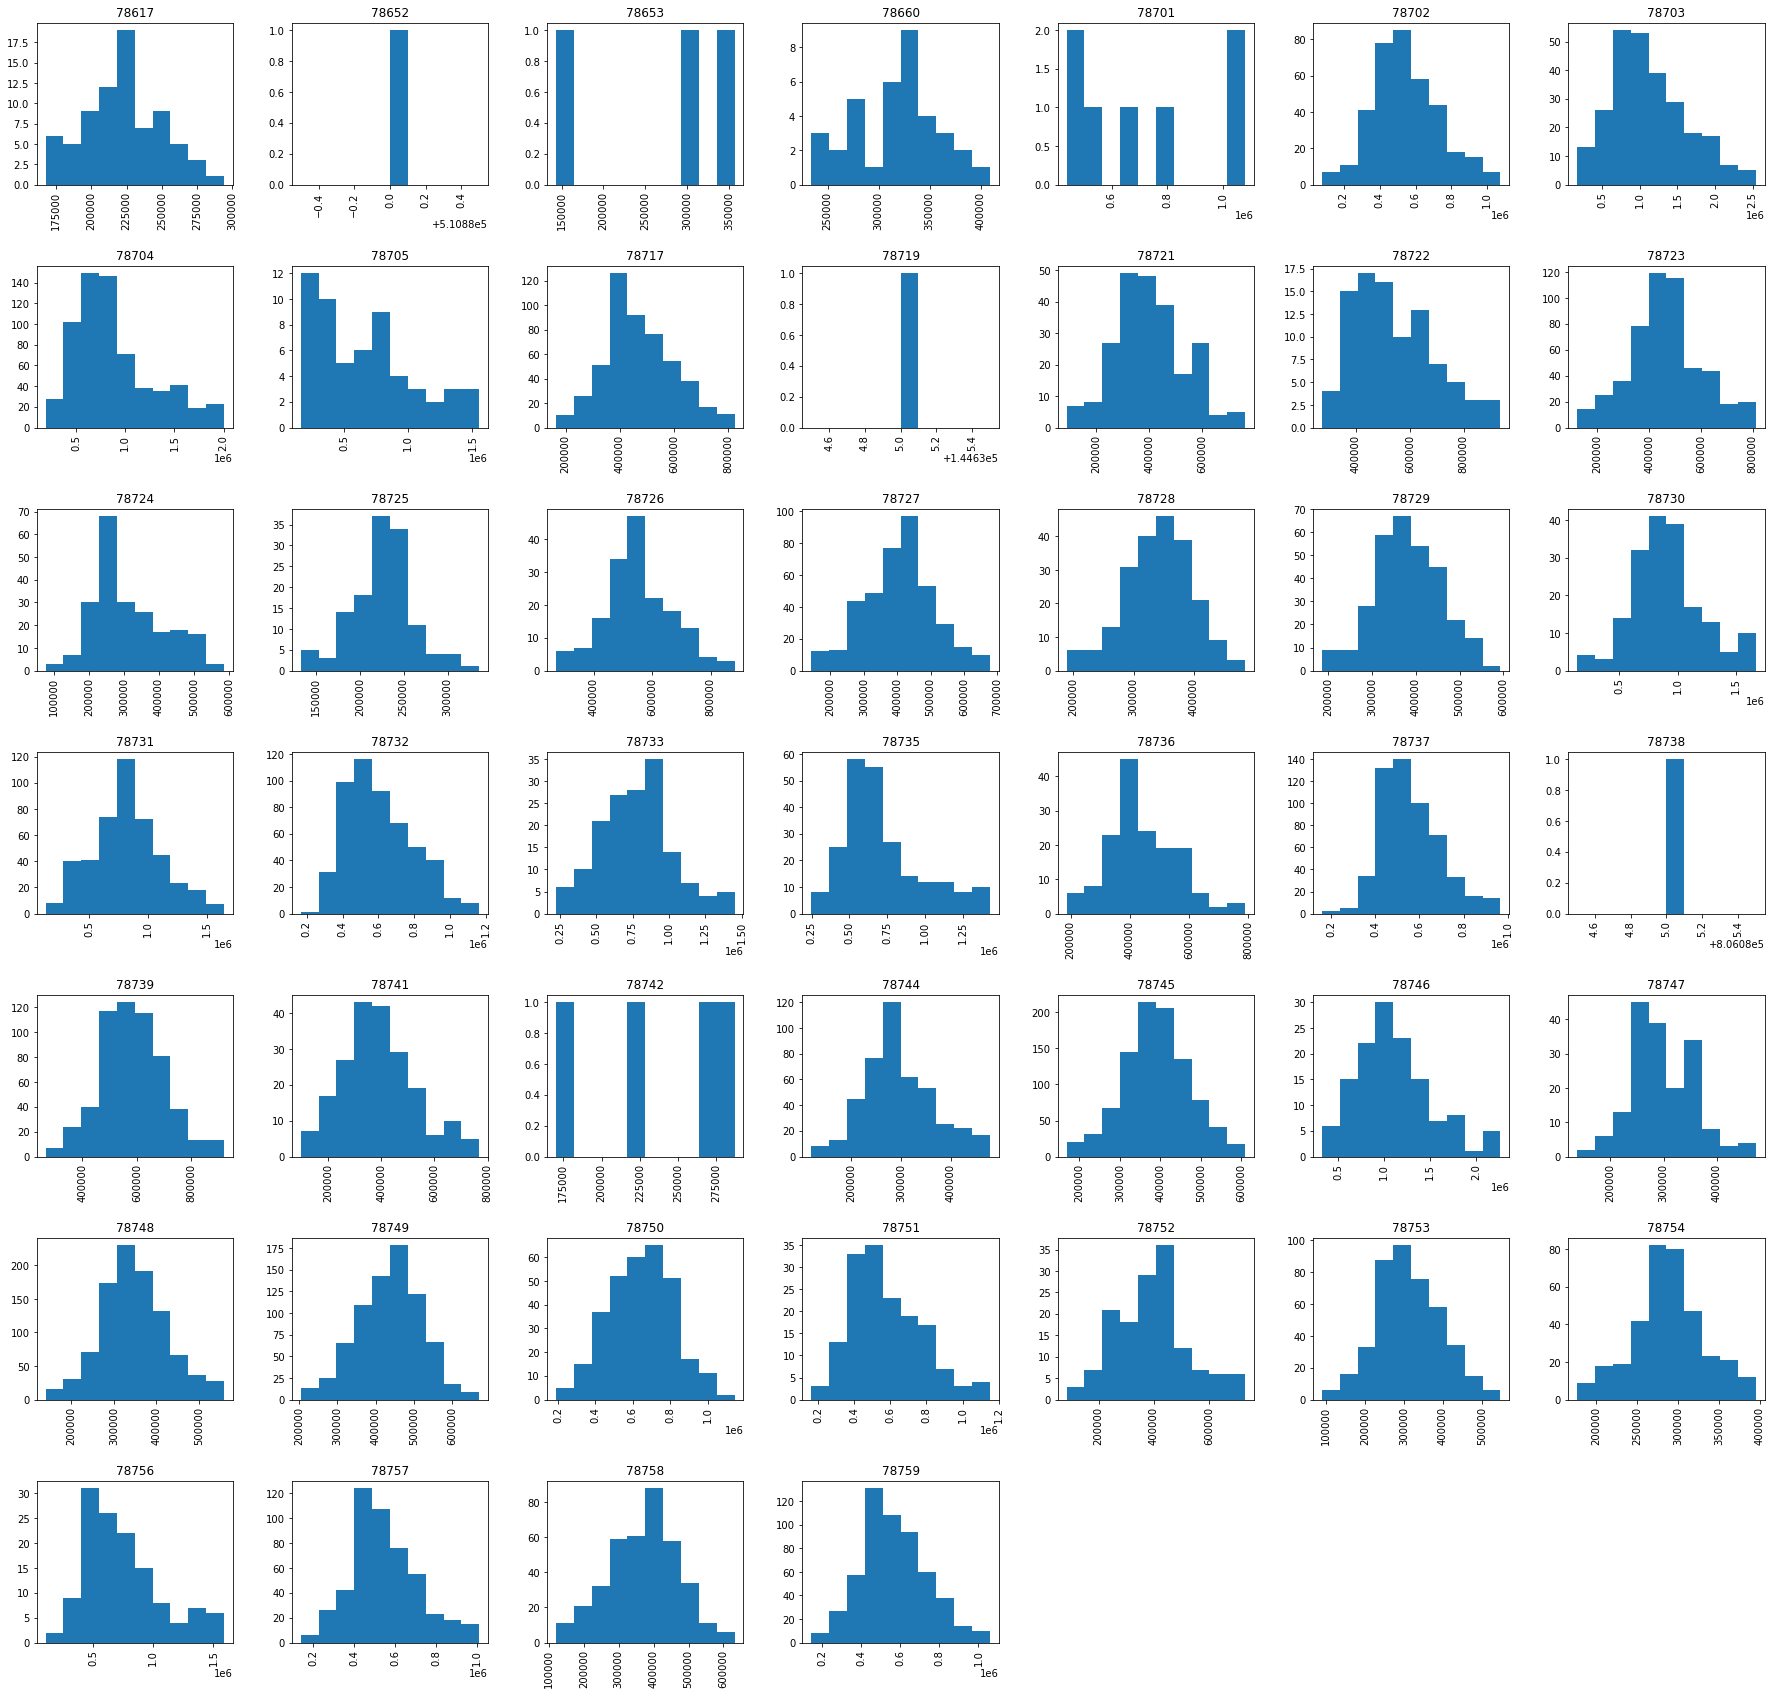

In [660]:
#check our price per zip code histograms.

df['price'].hist(by=df['zipcode'], figsize=(30,30));    

In [661]:
# drop a few zip codes where we have only a couple of data points

df.drop( df.loc[(df['zipcode']==78653) | (df['zipcode']==78738) | (df['zipcode']==78719)| (df['zipcode']==78652)| (df['zipcode']==78742)].index, axis=0, inplace=True)

In [662]:
# redo our zip code medians and rankings after outlier removal

# apply the median home price per zip code to the data frame again after outlier removal
df['median_zip'] = df['zipcode'].apply(lambda x: round(df.loc[df['zipcode']==x]['price'].median(), 0))

# group our dataframe by zipcode on median home price, sorted ascending. We want to bin like-medians together.
zipsorted = pd.DataFrame(df.groupby('zipcode')['price'].median().sort_values(ascending=True))

# divide our dataframe into groups with entries per group as specified above,
# and assign this number to a new column
zipsorted['rank'] = np.divmod(np.arange(len(zipsorted)), 1)[0]+1

# make a new column on our dataframe. Look up each zip entry's group, and append to the column.
df['zip_rank'] = df['zipcode'].apply(lambda x: make_group(x, zipsorted, 'rank'))

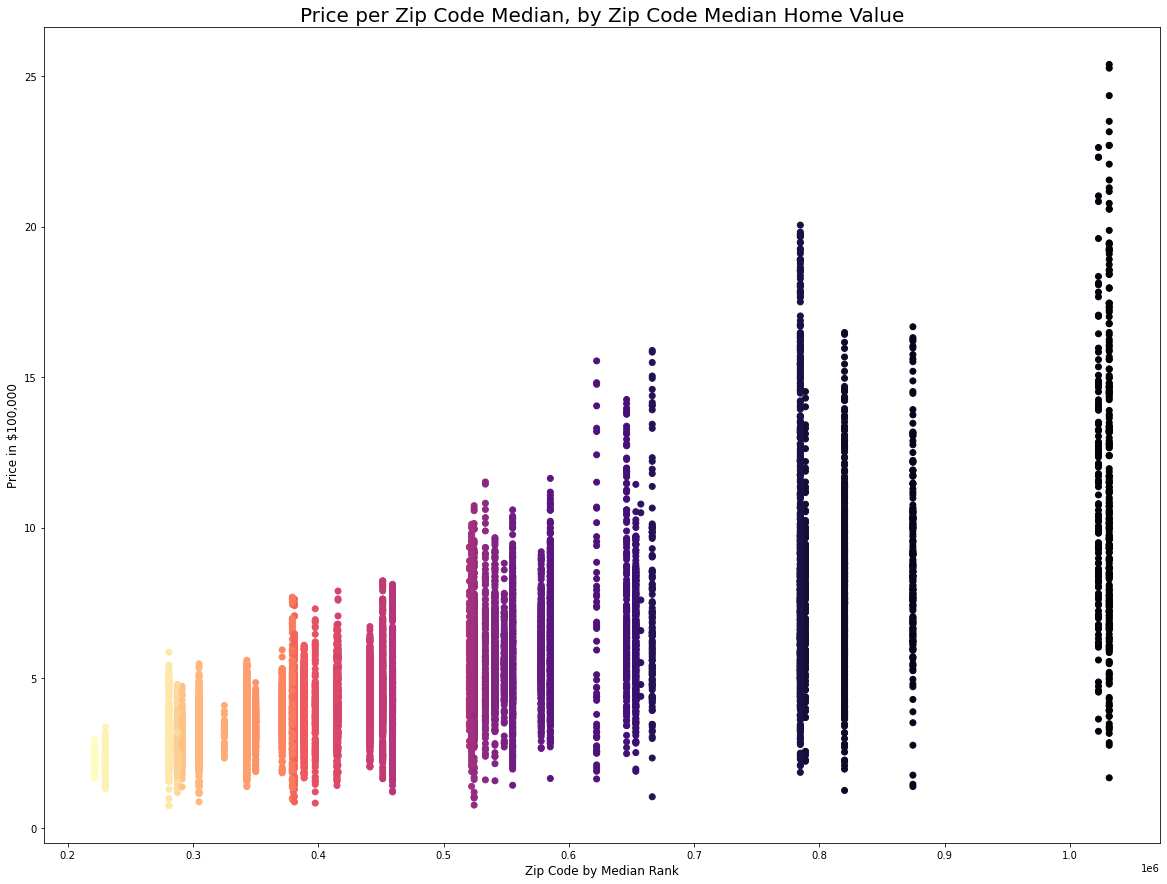

In [663]:
# re-visualize zip code as a color function, using the median zip after outlier removal. 

fig, ax = plt.subplots(figsize=(20, 15))

ax.scatter(df['median_zip'], df['price'] /100000, c=df['zip_rank'], cmap='magma_r')

ax.set_xlabel('Zip Code by Median Rank', fontsize=12)
ax.set_ylabel('Price in $100,000', fontsize=12)
ax.set_title('Price per Zip Code Median, by Zip Code Median Home Value', fontsize=20);

In [664]:
# apply the median price per square foot per zip code to the data frame
df['pr_sqft'] = df.apply(lambda x: round( (x['price'] / x['livingAreaSqFt'] ), 0), axis=1 )

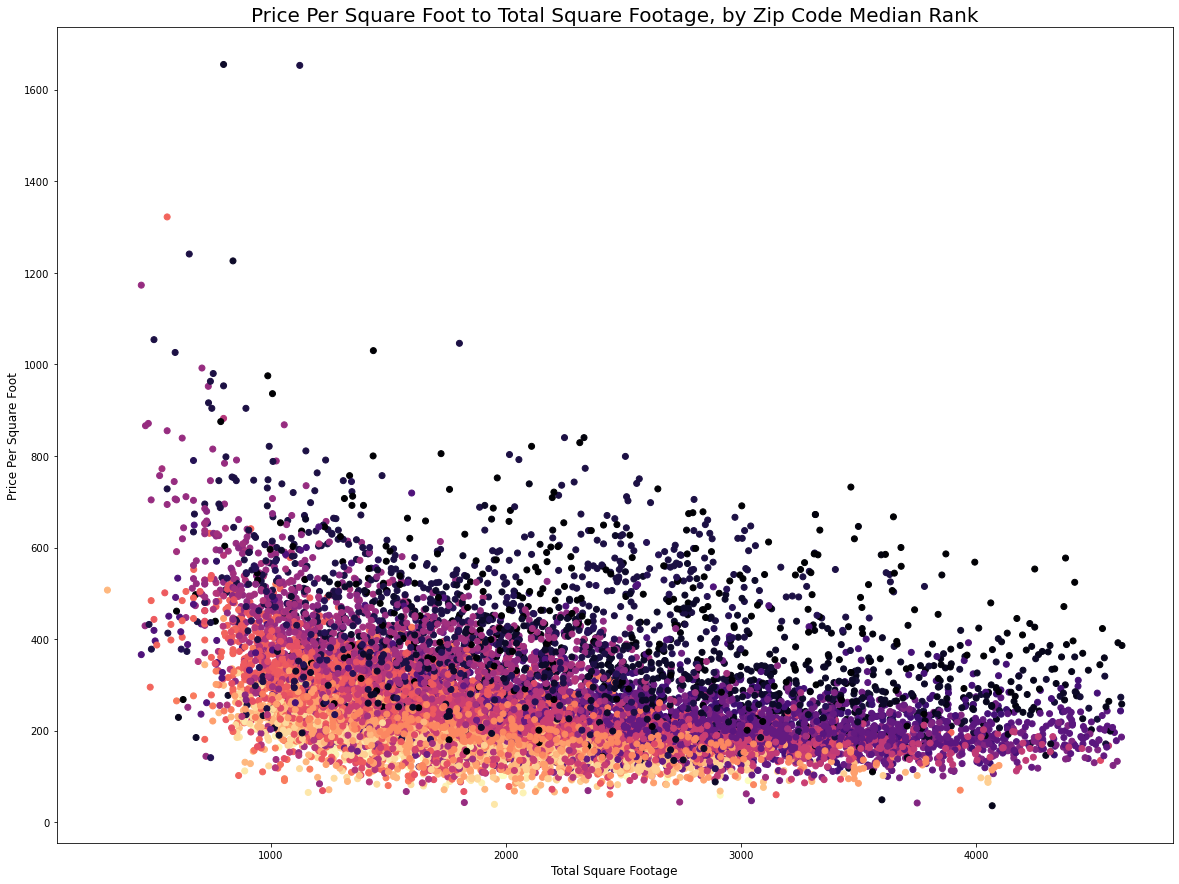

In [665]:
fig, ax = plt.subplots(figsize=(20, 15))

ax.scatter(df['livingAreaSqFt'], df['pr_sqft'], c=df['zip_rank'], cmap='magma_r')

ax.set_xlabel('Total Square Footage', fontsize=12)
ax.set_ylabel('Price Per Square Foot', fontsize=12)
ax.set_title('Price Per Square Foot to Total Square Footage, by Zip Code Median Rank', fontsize=20);

In [666]:
#dropping irrationally high pr/sqft
df.drop(df[df['pr_sqft']>1000].index, inplace=True)

Text(0.5, 1.0, 'Price per Total Square Footage, by Zip Code Median Rank')

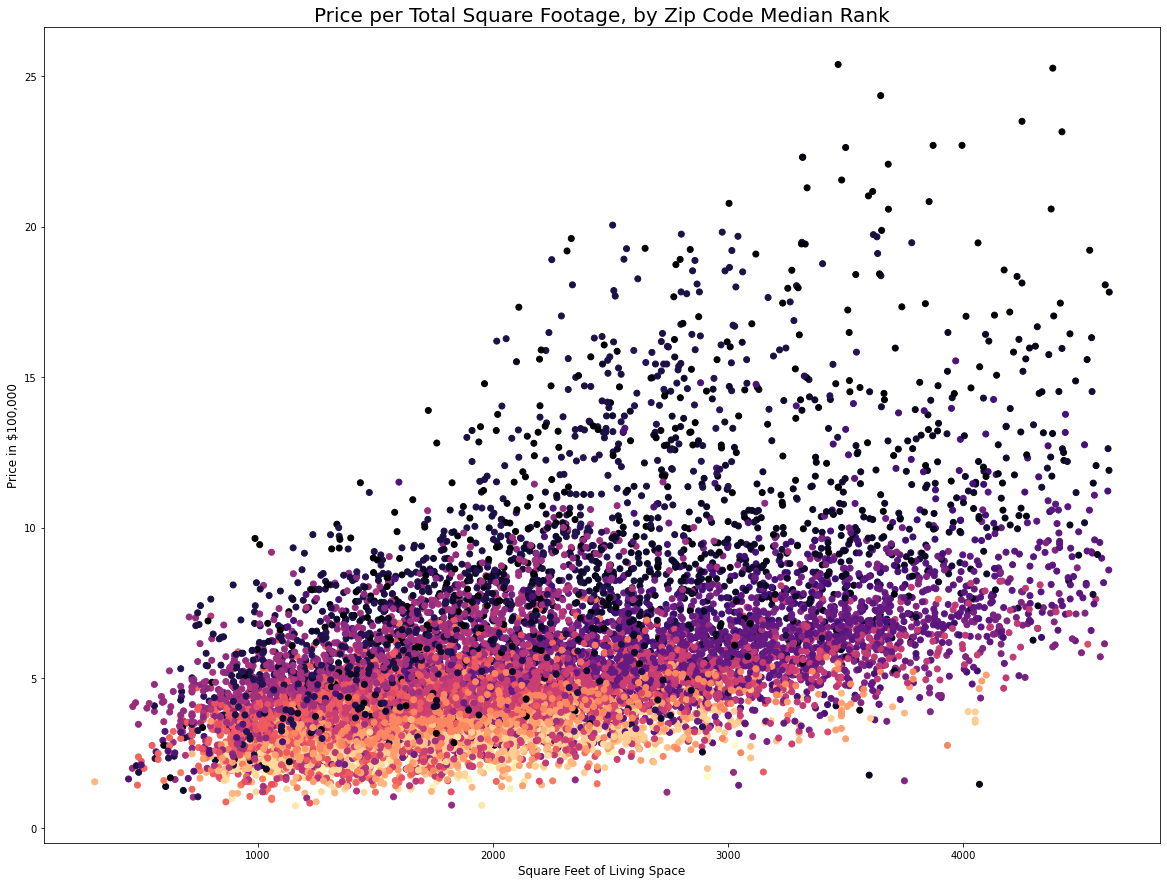

In [667]:
# visualize zip code as a color function, on a plot of price per square footage

fig, ax = plt.subplots(figsize=(20, 15))

ax.scatter(df['livingAreaSqFt'], df['price'] /100000, c=df['zip_rank'], cmap='magma_r')

ax.set_xlabel('Square Feet of Living Space', fontsize=12)
ax.set_ylabel('Price in $100,000', fontsize=12)
ax.set_title('Price per Total Square Footage, by Zip Code Median Rank', fontsize=20)

In [668]:
low_zips = df.loc[df['median_zip']<df['price'].mean()]
high_zips = df.loc[df['median_zip']>=df['price'].mean()]

''

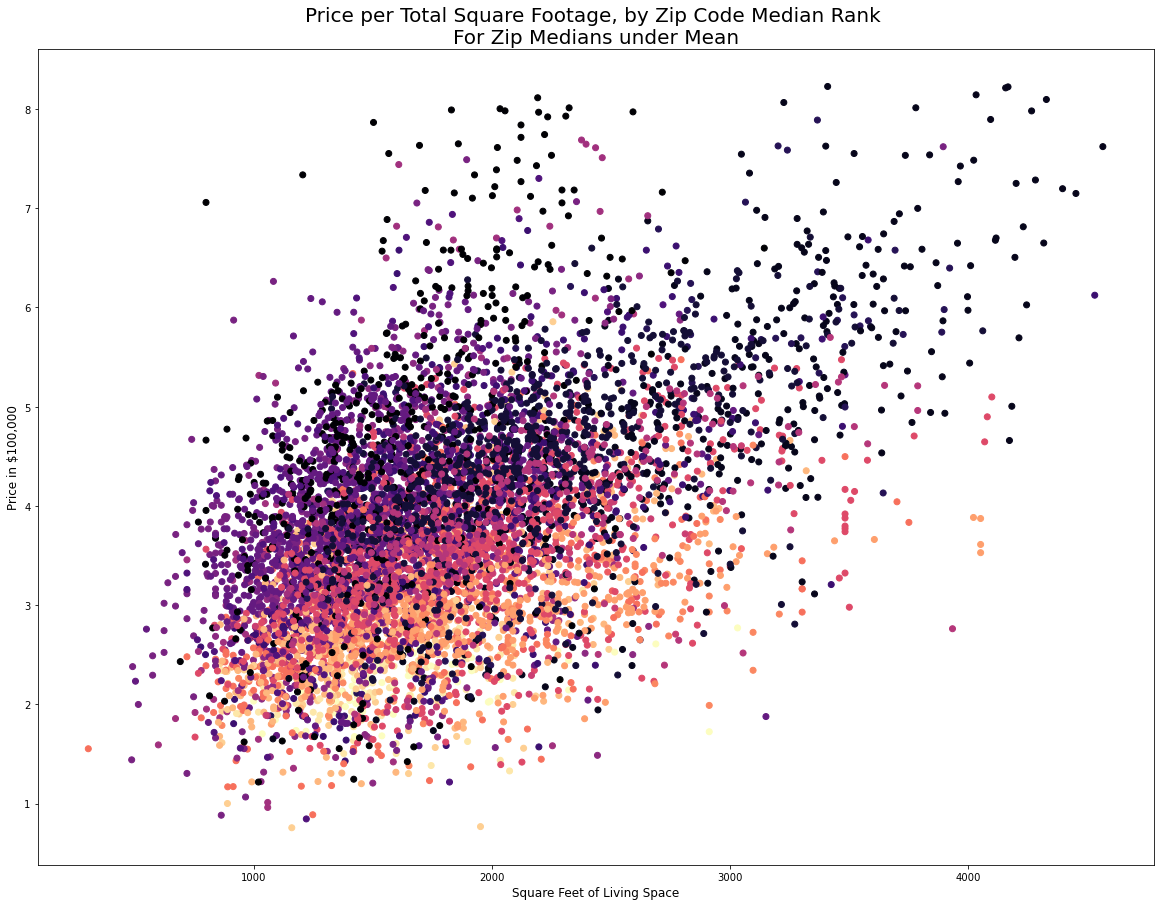

In [669]:
# visualize zip code as a color function, on a plot of price per square footage

fig, ax = plt.subplots(figsize=(20, 15))

ax.scatter(low_zips['livingAreaSqFt'], low_zips['price'] /100000, c=low_zips['zip_rank'], cmap='magma_r')

ax.set_xlabel('Square Feet of Living Space', fontsize=12)
ax.set_ylabel('Price in $100,000', fontsize=12)
ax.set_title('Price per Total Square Footage, by Zip Code Median Rank \nFor Zip Medians under Mean', fontsize=20)
;


''

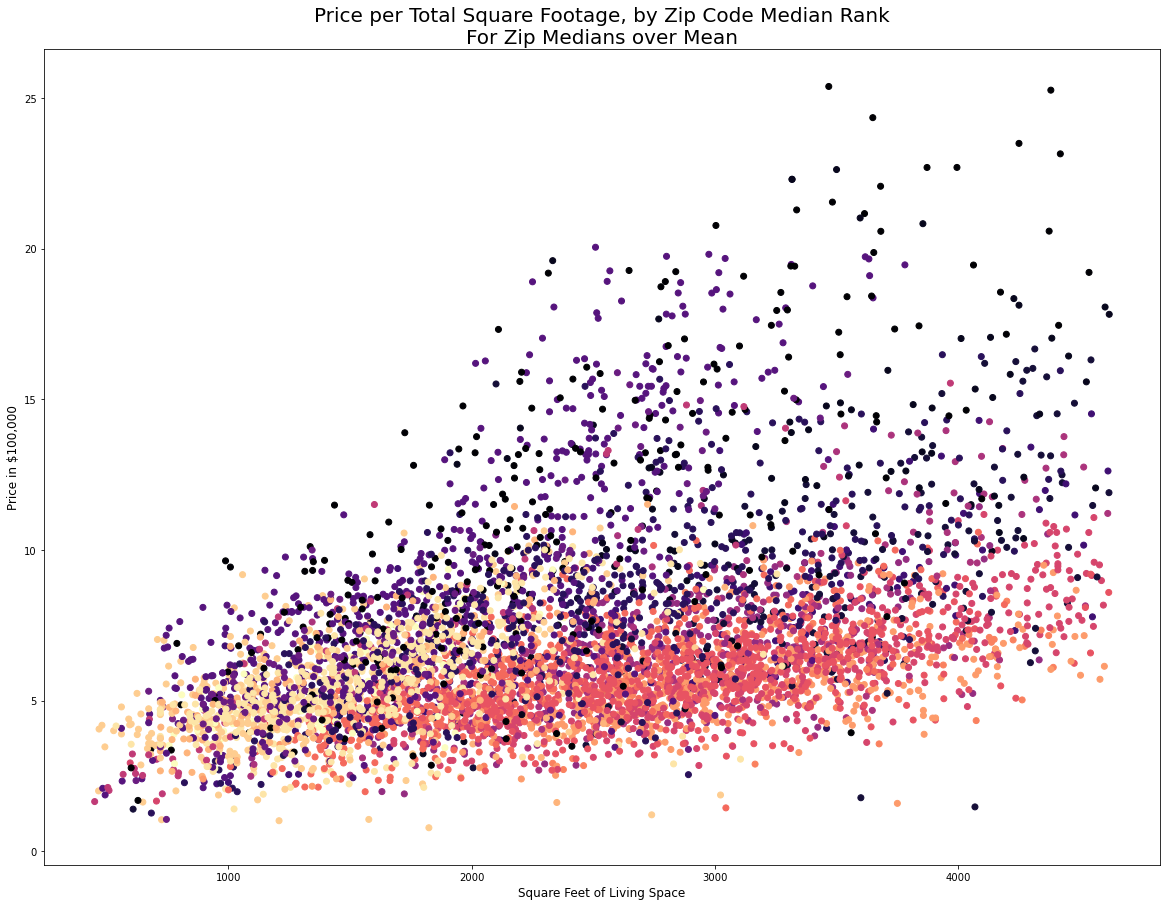

In [670]:
# visualize zip code as a color function, on a plot of price per square footage

fig, ax = plt.subplots(figsize=(20, 15))

ax.scatter(high_zips['livingAreaSqFt'], high_zips['price'] /100000, c=high_zips['zip_rank'], cmap='magma_r')

ax.set_xlabel('Square Feet of Living Space', fontsize=12)
ax.set_ylabel('Price in $100,000', fontsize=12)
ax.set_title('Price per Total Square Footage, by Zip Code Median Rank\nFor Zip Medians over Mean', fontsize=20)
;

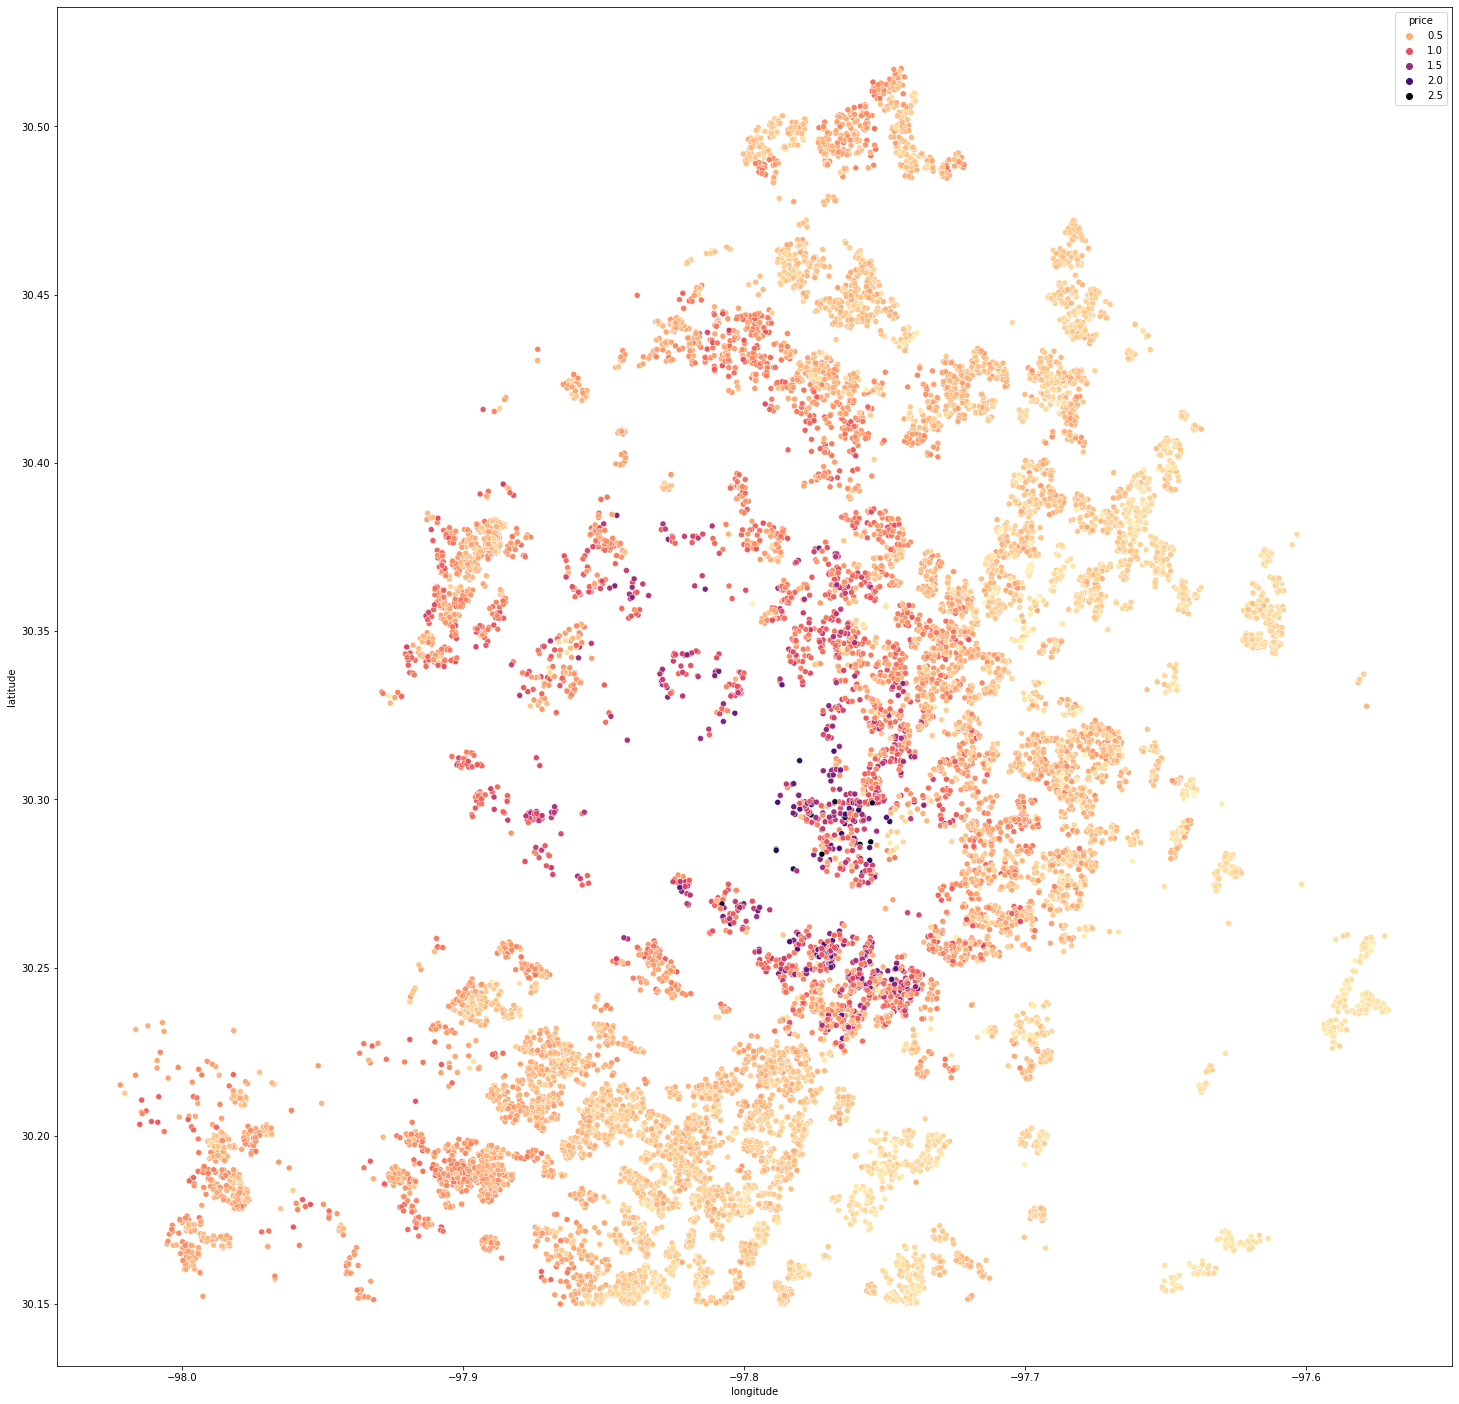

In [671]:
# plotting latitude and longitude as a visual scatter plot based on price. 
plt.figure(figsize=(25,25))

sns.scatterplot(data=df, x="longitude", y="latitude", hue="price", palette="magma_r");

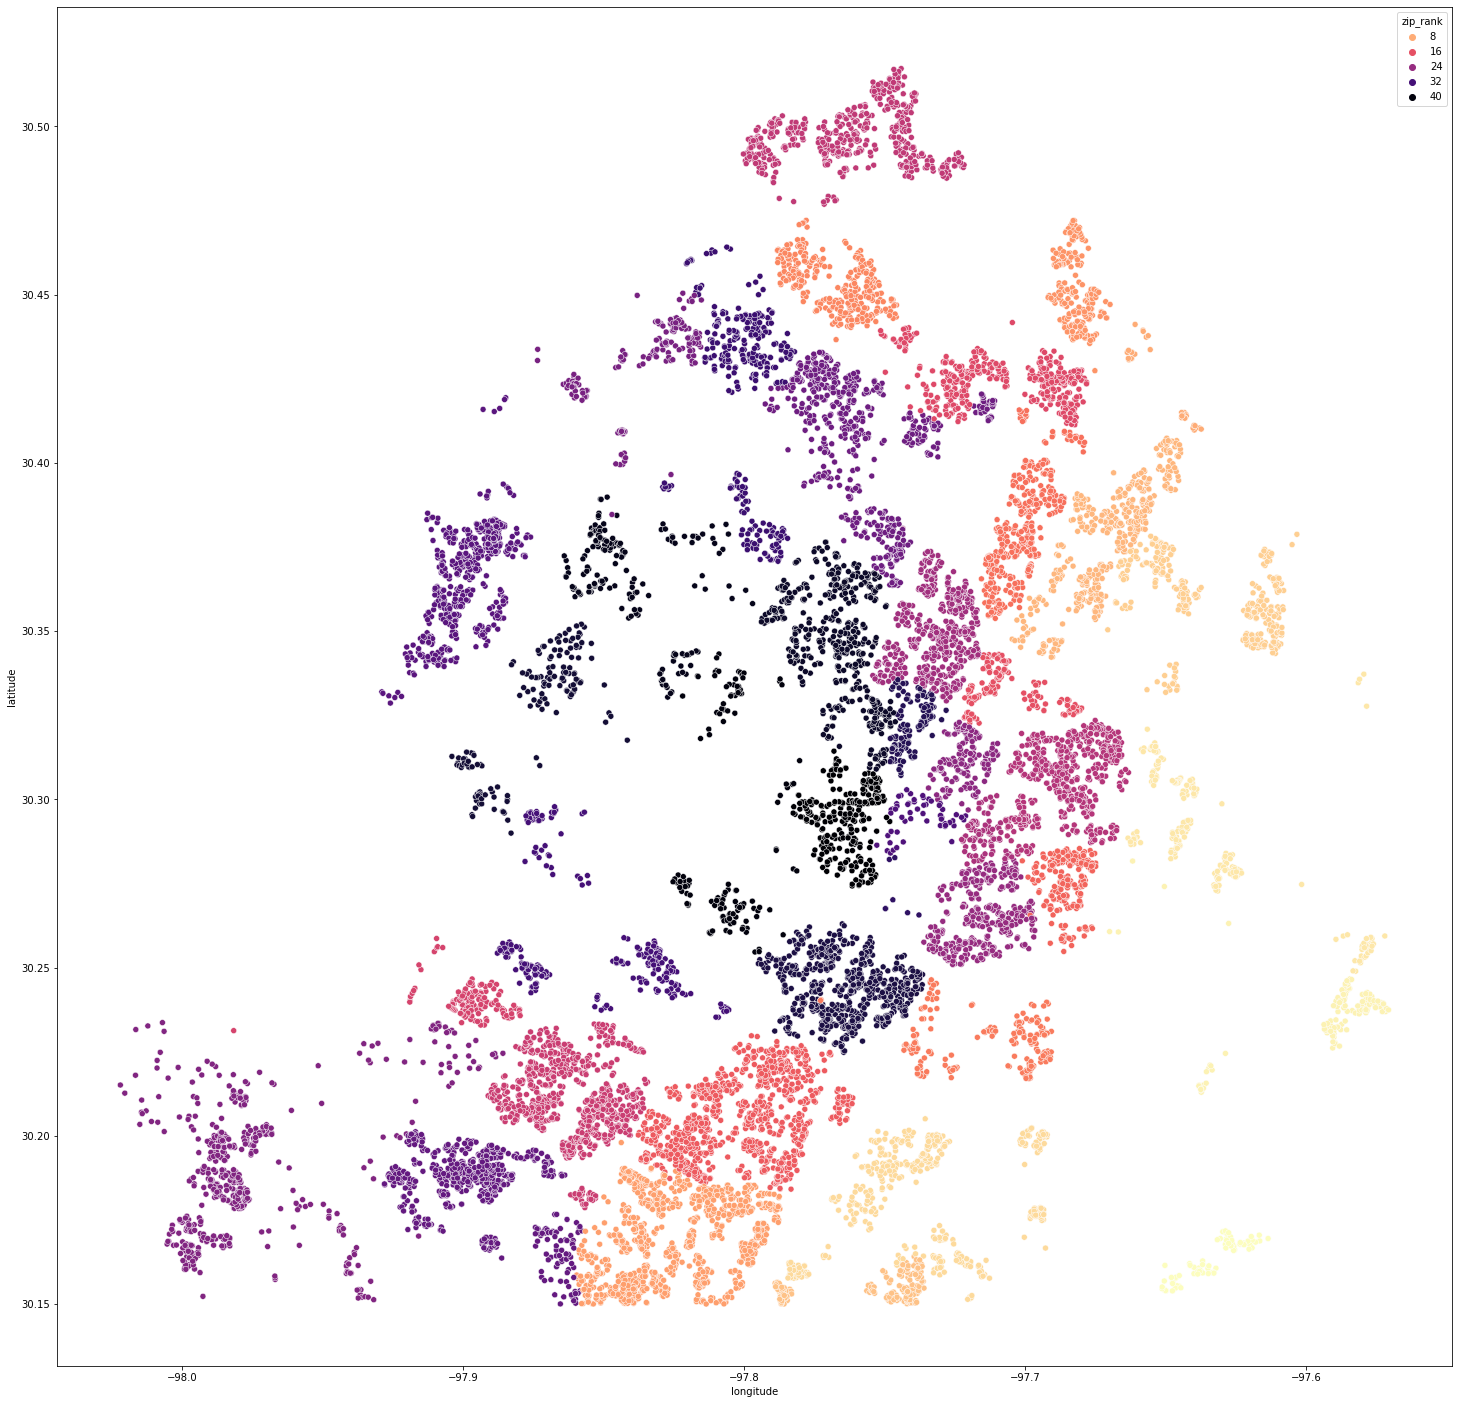

In [672]:
# plotting latitude and longitude as a visual scatter plot based on zip_rank. 
plt.figure(figsize=(25,25))

sns.scatterplot(data=df, x="longitude", y="latitude", hue="zip_rank", palette="magma_r");

In [673]:
# look for nulls
df.isna().sum()

price                         0
zpid                          0
city                          0
streetAddress                 0
zipcode                       0
description                   0
latitude                      0
longitude                     0
propertyTaxRate               0
garageSpaces                  0
hasAssociation                0
hasCooling                    0
hasGarage                     0
hasHeating                    0
hasSpa                        0
hasView                       0
homeType                      0
parkingSpaces                 0
yearBuilt                     0
orig_price                    0
numPriceChanges               0
latest_saledate               0
latest_salemonth              0
latest_saleyear               0
latestPriceSource             0
numOfPhotos                   0
numOfAccessibilityFeatures    0
numOfAppliances               0
numOfParkingFeatures          0
numOfPatioAndPorchFeatures    0
numOfSecurityFeatures         0
numOfWat

In [674]:
# verify types
df.dtypes

price                         float64
zpid                            int64
city                           object
streetAddress                  object
zipcode                         int64
description                    object
latitude                      float64
longitude                     float64
propertyTaxRate               float64
garageSpaces                    int64
hasAssociation                   bool
hasCooling                       bool
hasGarage                        bool
hasHeating                       bool
hasSpa                           bool
hasView                          bool
homeType                       object
parkingSpaces                   int64
yearBuilt                       int64
orig_price                    float64
numPriceChanges                 int64
latest_saledate                object
latest_salemonth                int64
latest_saleyear                 int64
latestPriceSource              object
numOfPhotos                     int64
numOfAccessi

In [675]:
# convert to binary to simplify the model
convert_to_bool = ['numOfAccessibilityFeatures', 'numOfAppliances', 'numOfParkingFeatures', 'numOfPatioAndPorchFeatures', 'numOfSecurityFeatures', 'numOfWaterfrontFeatures', 'numOfWindowFeatures', 'numOfCommunityFeatures']

df_convert_to_bool = df[convert_to_bool]
df_convert_to_bool.describe()

numOfAccessibilityFeatures  numOfAppliances  numOfParkingFeatures  \
count                13603.000000     13603.000000          13603.000000   
mean                     0.013012         3.471514              1.699772   
std                      0.182835         1.866988              0.779454   
min                      0.000000         0.000000              0.000000   
25%                      0.000000         2.000000              1.000000   
50%                      0.000000         3.000000              2.000000   
75%                      0.000000         4.000000              2.000000   
max                      8.000000        10.000000              6.000000   

       numOfPatioAndPorchFeatures  numOfSecurityFeatures  \
count                13603.000000           13603.000000   
mean                     0.654856               0.462766   
std                      0.968499               0.816672   
min                      0.000000               0.000000   
25%                      0.000000               0.000000   
50%                      0.000000               0.000000   
75%                      1.000000               1.000000   
max                      8.000000               6.000000   

       numOfWaterfrontFeatures  numOfWindowFeatures  numOfCommunityFeatures  
count             13603.000000         13603.000000            13603.000000  
mean                  0.001323             0.205616                0.011615  
std                   0.040195             0.483813                0.112505  
min                   0.000000             0.000000                0.000000  
25%                   0.000000             0.000000                0.000000  
50%                   0.000000             0.000000                0.000000  
75%                   0.000000             0.000000                0.000000  
max                   2.000000             3.000000                3.000000

In [676]:
# Any element that has no features by the 50th percentile is getting converted to a binary 

# change all non-null values > 0 in those columns to 1
df.loc[df['numOfAccessibilityFeatures'] > 0, 'numOfAccessibilityFeatures'] = 1
df.loc[df['numOfPatioAndPorchFeatures'] > 0, 'numOfPatioAndPorchFeatures'] = 1
df.loc[df['numOfSecurityFeatures'] > 0, 'numOfSecurityFeatures'] = 1
df.loc[df['numOfWaterfrontFeatures'] > 0, 'numOfWaterfrontFeatures'] = 1
df.loc[df['numOfWindowFeatures'] > 0, 'numOfWindowFeatures'] = 1
df.loc[df['numOfCommunityFeatures'] > 0, 'numOfCommunityFeatures'] = 1

# now anything that is not a 1 becomes a 0
df.loc[df['numOfAccessibilityFeatures']!= 1, 'numOfAccessibilityFeatures'] = 0
df.loc[df['numOfPatioAndPorchFeatures'] != 1, 'numOfPatioAndPorchFeatures'] = 0
df.loc[df['numOfSecurityFeatures'] != 1, 'numOfSecurityFeatures'] = 0
df.loc[df['numOfWaterfrontFeatures'] != 1, 'numOfWaterfrontFeatures'] = 0
df.loc[df['numOfWindowFeatures'] != 1, 'numOfWindowFeatures'] = 0
df.loc[df['numOfCommunityFeatures'] != 1, 'numOfCommunityFeatures'] = 0

# rename to reflect binary
df.rename(columns={'numOfAccessibilityFeatures' : 'accessibility', 'numOfPatioAndPorchFeatures' : 'patioporch', 'numOfSecurityFeatures': 'security', 
                  'numOfWaterfrontFeatures': 'waterfront', 'numOfWindowFeatures' : 'windowfeatures', 'numOfCommunityFeatures' : 'community'}, inplace=True)

# convert original boolean columns to binary 0/1
boolean = ['hasAssociation', 'hasCooling', 'hasGarage', 'hasHeating', 'hasSpa', 'hasView']

for item in boolean:
    df[boolean] = df[boolean].astype(int)

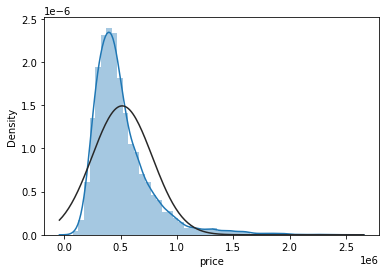

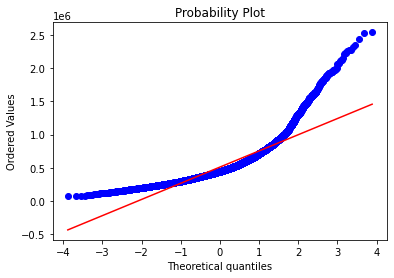

In [677]:
#histogram and normal probability plot to look at target variable is normally distributed.
sns.distplot(df['price'], fit=norm);
fig = plt.figure()

res = stats.probplot(df['price'], plot=plt)

# histogram is positiviely skewed
# Prob plot is skewed right


In [678]:
#skewness and kurtosis
# Skewness essentially measures the symmetry of the distribution, while kurtosis determines the heaviness of the distribution tails.” 
# The understanding shape of data is a crucial action. It helps to understand where the most information is lying and analyze the outliers in a given data.

print("Skewness: %f" % df['price'].skew())
print("Kurtosis: %f" % df['price'].kurt())

# price is skewed to the right
# kurtosis is positive with a heavy tail

Skewness: 2.140536
Kurtosis: 6.939968


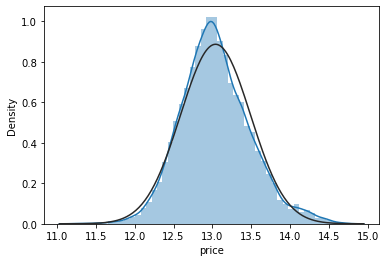

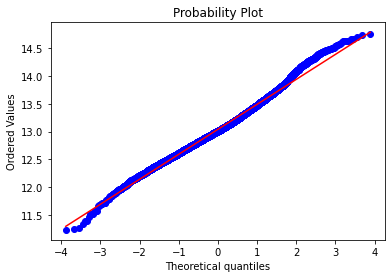

In [679]:
# log transform our target price to try and improve normality of distribution
# The log-transformation is widely used in biomedical and psychosocial research to deal with skewed data
df_target_log = np.log(df['price'])

#histogram and normal probability plot
sns.distplot(df_target_log, fit=norm);
fig = plt.figure()
res = stats.probplot(df_target_log, plot=plt)

# target price is more normally distributed - log will be used going forward.

In [680]:
# reset indices on original data frame before making a copy
df.reset_index(inplace=True)
df.drop('index', axis=1, inplace=True)

In [681]:
# # append listing text to original data frame
# df = pd.concat([df, listing_text], axis=1)

df

price        zpid          city                   streetAddress  \
0      328625.0   111373431  pflugerville            14424 Lake Victor Dr   
1      309233.0   120900430  pflugerville              1104 Strickling Dr   
2      286036.0  2084491383  pflugerville             1408 Fort Dessau Rd   
3      265930.0   120901374  pflugerville              1025 Strickling Dr   
4      255324.0    60134862  pflugerville           15005 Donna Jane Loop   
...         ...         ...           ...                             ...   
13598  289006.0    29504086        austin                   9013 Marsh Dr   
13599  335307.0    29512934        austin                 905 Silcantu Dr   
13600  558845.0   241937773        austin  1413 Waterloo Shore Ln UNIT 12   
13601  875000.0    29473281        austin                   2206 S 3rd St   
13602  374900.0    29390174        austin                  3110 E 12th St   

       zipcode                                        description   latitude  \
0        78660  14424 Lake Victor Dr, Pflugerville, TX 78660 i...  30.430632   
1        78660  Absolutely GORGEOUS 4 Bedroom home with 2 full...  30.432673   
2        78660  Under construction - estimated completion in A...  30.409748   
3        78660  Absolutely darling one story home in charming ...  30.432112   
4        78660  Brimming with appeal & warm livability! Sleek ...  30.437368   
...        ...                                                ...        ...   
13598    78748  This 3 bedroom home is nestled among mature sh...  30.185915   
13599    78748  Not for rent!\n\nBeautiful one story home in T...  30.161997   
13600    78741  This contemporary three-story detached condo h...  30.240223   
13601    78704  Original bungalow with a modern addition. Larg...  30.244835   
13602    78702  3110 E 12th St, Austin, TX 78702 is a single f...  30.276930   

       longitude  propertyTaxRate  garageSpaces  hasAssociation  hasCooling  \
0     -97.663078             1.98             2               1           1   
1     -97.661697             1.98             2               1           1   
2     -97.639771             1.98             0               1           1   
3     -97.661659             1.98             2               1           1   
4     -97.656860             1.98             0               1           1   
...          ...              ...           ...             ...         ...   
13598 -97.828415             1.98             2               0           1   
13599 -97.816345             1.98             3               0           1   
13600 -97.772835             1.98             2               1           1   
13601 -97.761124             1.98             2               0           1   
13602 -97.701523             1.98             1               0           1   

       hasGarage  hasHeating  hasSpa  hasView       homeType  parkingSpaces  \
0              1           1       0        0  Single Family              2   
1              1           1       0        0  Single Family              2   
2              0           1       0        0  Single Family              0   
3              1           1       0        0  Single Family              2   
4              0           1       0        0  Single Family              0   
...          ...         ...     ...      ...            ...            ...   
13598          1           1       1        0  Single Family              2   
13599          1           1       0        1  Single Family              5   
13600          1           1       1        1  Single Family              2   
13601          1           1       0        0  Single Family              2   
13602          1           1       0        1  Single Family              1   

       yearBuilt  orig_price  numPriceChanges latest_saledate  \
0           2012    305000.0                5      2019-09-02   
1           2013    295000.0                1      2020-10-13   
2           2018    256125.0   

In [682]:
# Create a holdout set and set randomstate

randomstate = 2

y = pd.DataFrame(df['price'])
x = df.drop('price', axis=1,)

# train/validation sets and our test sets
train_data, holdout, y_train, y_test = train_test_split(df, y, test_size=0.2, random_state=randomstate)

# reset indices to prevent any index mismatches
train_data.reset_index(inplace=True)
train_data.drop('index', axis=1, inplace=True)

holdout.reset_index(inplace=True)
holdout.drop('index', axis=1, inplace=True)

y_train.reset_index(inplace=True, drop=True)
y_test.reset_index(inplace=True, drop=True)

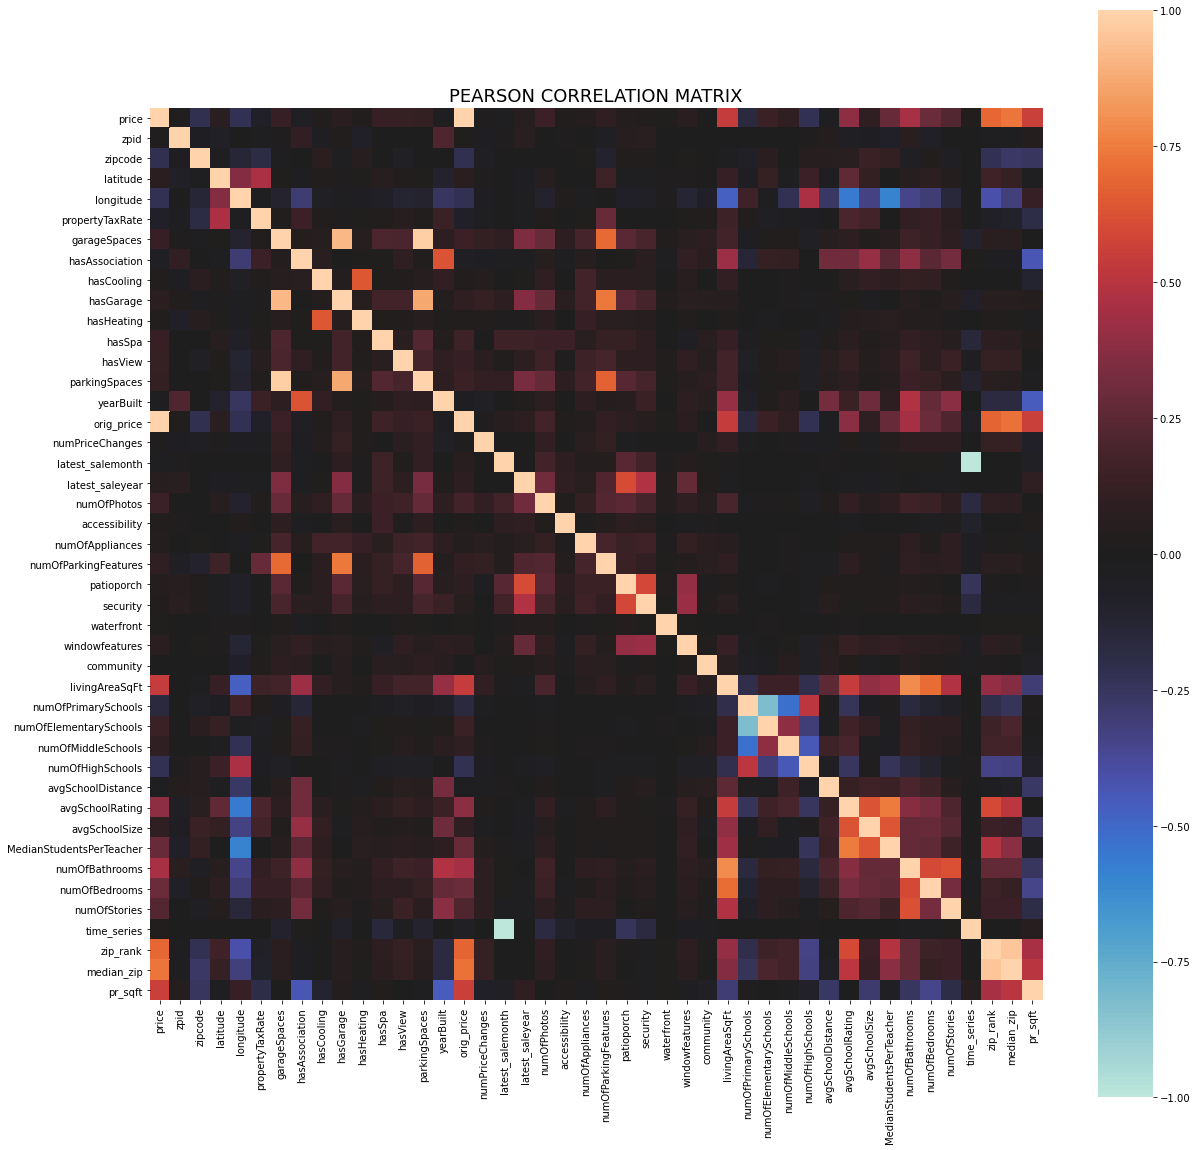

In [683]:
# look for multicollinearity of features with Pearson Correlation Matrix
fig, ax = plt.subplots(figsize=(20, 20))

sns.heatmap(train_data.corr(), center=0,  
           vmin=-1, vmax=1,  square=True)

# title
plt.title('PEARSON CORRELATION MATRIX', fontsize=18)

plt.show()

In [684]:
train_data.corr()

price      zpid   zipcode  latitude  longitude  \
price                     1.000000  0.014297 -0.214331  0.069964  -0.222662   
zpid                      0.014297  1.000000 -0.042770 -0.065226   0.001227   
zipcode                  -0.214331 -0.042770  1.000000 -0.031321  -0.139686   
latitude                  0.069964 -0.065226 -0.031321  1.000000   0.362708   
longitude                -0.222662  0.001227 -0.139686  0.362708   1.000000   
propertyTaxRate          -0.071191 -0.019297 -0.185156  0.465182  -0.017121   
garageSpaces              0.127951  0.012203 -0.017963  0.021338  -0.105567   
hasAssociation           -0.050183  0.102376 -0.013820 -0.034397  -0.296768   
hasCooling                0.034073 -0.042798  0.071249  0.034208  -0.062384   
hasGarage                 0.076280  0.033311 -0.028729  0.015057  -0.031945   
hasHeating                0.028166 -0.077236  0.047645  0.022212  -0.040053   
hasSpa                    0.128399  0.000373 -0.007458  0.052222  -0.063632   
hasView                   0.120332 -0.001306 -0.059854  0.033796  -0.120545   
parkingSpaces             0.116840  0.006543 -0.009047  0.018025  -0.104085   
yearBuilt                -0.018923  0.214882 -0.004183 -0.098942  -0.252024   
orig_price                0.992482  0.017367 -0.213451  0.067517  -0.221017   
numPriceChanges           0.010845 -0.046725 -0.048649  0.010831  -0.045568   
latest_salemonth         -0.038823  0.008102  0.001682 -0.003328  -0.004860   
latest_saleyear           0.061138  0.063132 -0.007443 -0.046736  -0.026178   
numOfPhotos               0.144777 -0.014712 -0.011164  0.051089  -0.099297   
accessibility             0.025193  0.010039 -0.007919 -0.008835   0.023876   
numOfAppliances           0.040931  0.007003  0.020741  0.005008  -0.023482   
numOfParkingFeatures      0.096665 -0.051377 -0.093795  0.156014  -0.009108   
patioporch                0.046399  0.049693  0.027336 -0.029241  -0.077503   
security                  0.028740  0.066484  0.028429 -0.034983  -0.069326   
waterfront                0.020091 -0.005605 -0.006824  0.012154   0.008236   
windowfeatures            0.063692 -0.008375  0.020202  0.012727  -0.125974   
community                -0.008464 -0.007098  0.002243 -0.003204  -0.076632   
livingAreaSqFt            0.544181 -0.012263 -0.027367  0.131908  -0.472317   
numOfPrimarySchools      -0.162967 -0.007747 -0.062914 -0.044142   0.162474   
numOfElementarySchools    0.135242  0.007557  0.071082  0.118451  -0.021881   
numOfMiddleSchools        0.097731  0.000456 -0.012067 -0.034172  -0.222855   
numOfHighSchools         -0.221968  0.012791  0.051404  0.141810   0.468683   
avgSchoolDistance        -0.019671  0.045502  0.047212 -0.038743  -0.262238   
avgSchoolRating           0.386720 -0.046988  0.068512  0.260417  -0.556885   
avgSchoolSize             0.097815 -0.042155  0.135732  0.110998  -0.330059   
MedianStudentsPerTeacher  0.287422 -0.074654  0.113510 -0.001636  -0.593475   
numOfBathrooms            0.453446  0.064279 -0.048200  0.052018  -0.350577   
numOfBedrooms             0.294497 -0.066163  0.035476  0.092011  -0.297806   
numOfStories              0.221043  0.002315 -0.052912  0.045790  -0.150741   
time_series               0.038823 -0.008102 -0.001682  0.003328   0.004860   
zip_rank                  0.688166 -0.028858 -0.219209  0.160200  -0.408822   
median_zip                0.726952 -0.019833 -0.270248  0.119214  -0.312858   
pr_sqft                   0.560218  0.040640 -0.254080 -0.038079   0.128537   

                          propertyTaxRate  garageSpaces  hasAssociation  \
price                           -0.071191      0.127951       -0.050183   
zpid                            -0.019297      0.012203        0.102376   
zipcode                         -0.185156     -0.017963       -0.013820   
latitude                         0.465182      0.021338       -0.034397   
longitude                       -0.017121     -0.105567       -0.296768   
propertyTaxRate        

In [685]:
#Get our list of highly correlated feature pairs with following steps:

# save correlation matrix as a new data frame
# converts all values to absolute value
# stacks the row:column pairs into a multindex
# reset the index to set the multindex to seperate columns
# sort values. 0 is the column automatically generated by the stacking
df_correlations = train_data.corr().abs().stack().reset_index().sort_values(0, ascending=False)

# zip the variable name columns in a new column named "pairs"
df_correlations['pairs'] = list(zip(df_correlations.level_0, df_correlations.level_1))

# set index to pairs
df_correlations.set_index(['pairs'], inplace = True)

# rename our results column to correlation
df_correlations.rename(columns={0: "correlation"}, inplace=True)

# Drop 1:1 correlations to get rid of self pairs
df_correlations.drop(df_correlations[df_correlations['correlation'] == 1.000000].index, inplace=True)

# view pairs above 75% correlation and below 90% correlation (engineered features will correlate with each other above 95%)
df_correlations[(df_correlations.correlation>.75) & (df_correlations.correlation<.95)]

level_0  \
pairs                                                                   
(garageSpaces, hasGarage)                                garageSpaces   
(hasGarage, garageSpaces)                                   hasGarage   
(parkingSpaces, hasGarage)                              parkingSpaces   
(hasGarage, parkingSpaces)                                  hasGarage   
(numOfElementarySchools, numOfPrimarySchools)  numOfElementarySchools   
(numOfPrimarySchools, numOfElementarySchools)     numOfPrimarySchools   
(numOfBathrooms, livingAreaSqFt)                       numOfBathrooms   
(livingAreaSqFt, numOfBathrooms)                       livingAreaSqFt   

                                                              level_1  \
pairs                                                                   
(garageSpaces, hasGarage)                                   hasGarage   
(hasGarage, garageSpaces)                                garageSpaces   
(parkingSpaces, hasGarage)                                  hasGarage   
(hasGarage, parkingSpaces)                              parkingSpaces   
(numOfElementarySchools, numOfPrimarySchools)     numOfPrimarySchools   
(numOfPrimarySchools, numOfElementarySchools)  numOfElementarySchools   
(numOfBathrooms, livingAreaSqFt)                       livingAreaSqFt   
(livingAreaSqFt, numOfBathrooms)                       numOfBathrooms   

                                               correlation  
pairs                                                       
(garageSpaces, hasGarage)                         0.920127  
(hasGarage, garageSpaces)                         0.920127  
(parkingSpaces, hasGarage)                        0.873151  
(hasGarage, parkingSpaces)                        0.873151  
(numOfElementarySchools, numOfPrimarySchools)     0.825045  
(numOfPrimarySchools, numOfElementarySchools)     0.825045  
(numOfBathrooms, livingAreaSqFt)                  0.793130  
(livingAreaSqFt, numOfBathrooms)                  0.793130

In [686]:
# Check out our variables correlationg with price
df_correlations = train_data.corr().abs().stack().reset_index().sort_values(0, ascending=False)
df_correlations.loc[df_correlations['level_0'] == 'price'].sort_values(0, ascending=False)

level_0                   level_1         0
0    price                     price  1.000000
15   price                orig_price  0.992482
42   price                median_zip  0.726952
41   price                  zip_rank  0.688166
43   price                   pr_sqft  0.560218
28   price            livingAreaSqFt  0.544181
37   price            numOfBathrooms  0.453446
34   price           avgSchoolRating  0.386720
38   price             numOfBedrooms  0.294497
36   price  MedianStudentsPerTeacher  0.287422
4    price                 longitude  0.222662
32   price          numOfHighSchools  0.221968
39   price              numOfStories  0.221043
2    price                   zipcode  0.214331
29   price       numOfPrimarySchools  0.162967
19   price               numOfPhotos  0.144777
30   price    numOfElementarySchools  0.135242
11   price                    hasSpa  0.128399
6    price              garageSpaces  0.127951
12   price                   hasView  0.120332
13   price             parkingSpaces  0.116840
35   price             avgSchoolSize  0.097815
31   price        numOfMiddleSchools  0.097731
22   price      numOfParkingFeatures  0.096665
9    price                 hasGarage  0.076280
5    price           propertyTaxRate  0.071191
3    price                  latitude  0.069964
26   price            windowfeatures  0.063692
18   price           latest_saleyear  0.061138
7    price            hasAssociation  0.050183
23   price                patioporch  0.046399
21   price           numOfAppliances  0.040931
17   price          latest_salemonth  0.038823
40   price               time_series  0.038823
8    price                hasCooling  0.034073
24   price                  security  0.028740
10   price                hasHeating  0.028166
20   price             accessibility  0.025193
25   price                waterfront  0.020091
33   price         avgSchoolDistance  0.019671
14   price                 yearBuilt  0.018923
1    price                      zpid  0.014297
16   price           numPriceChanges  0.010845
27   price                 community  0.008464

In [687]:
# combine all school counts into a single field
train_data['numOfSchools'] = train_data['numOfPrimarySchools'] + train_data['numOfElementarySchools'] + train_data['numOfMiddleSchools'] + train_data['numOfHighSchools']
holdout['numOfSchools'] = holdout['numOfPrimarySchools']  + holdout['numOfElementarySchools'] + holdout['numOfMiddleSchools'] + holdout['numOfHighSchools']

In [688]:
categories = ['zipcode', 'yearBuilt', 'hasAssociation', 'hasCooling', 'hasHeating', 'hasSpa', 'hasView', 'accessibility', 'patioporch', 'security',
          'waterfront', 'windowfeatures', 'community', 'latest_salemonth', 'numOfSchools', 'garageSpaces', 'propertyTaxRate', ]

df_categoricals = train_data[categories]

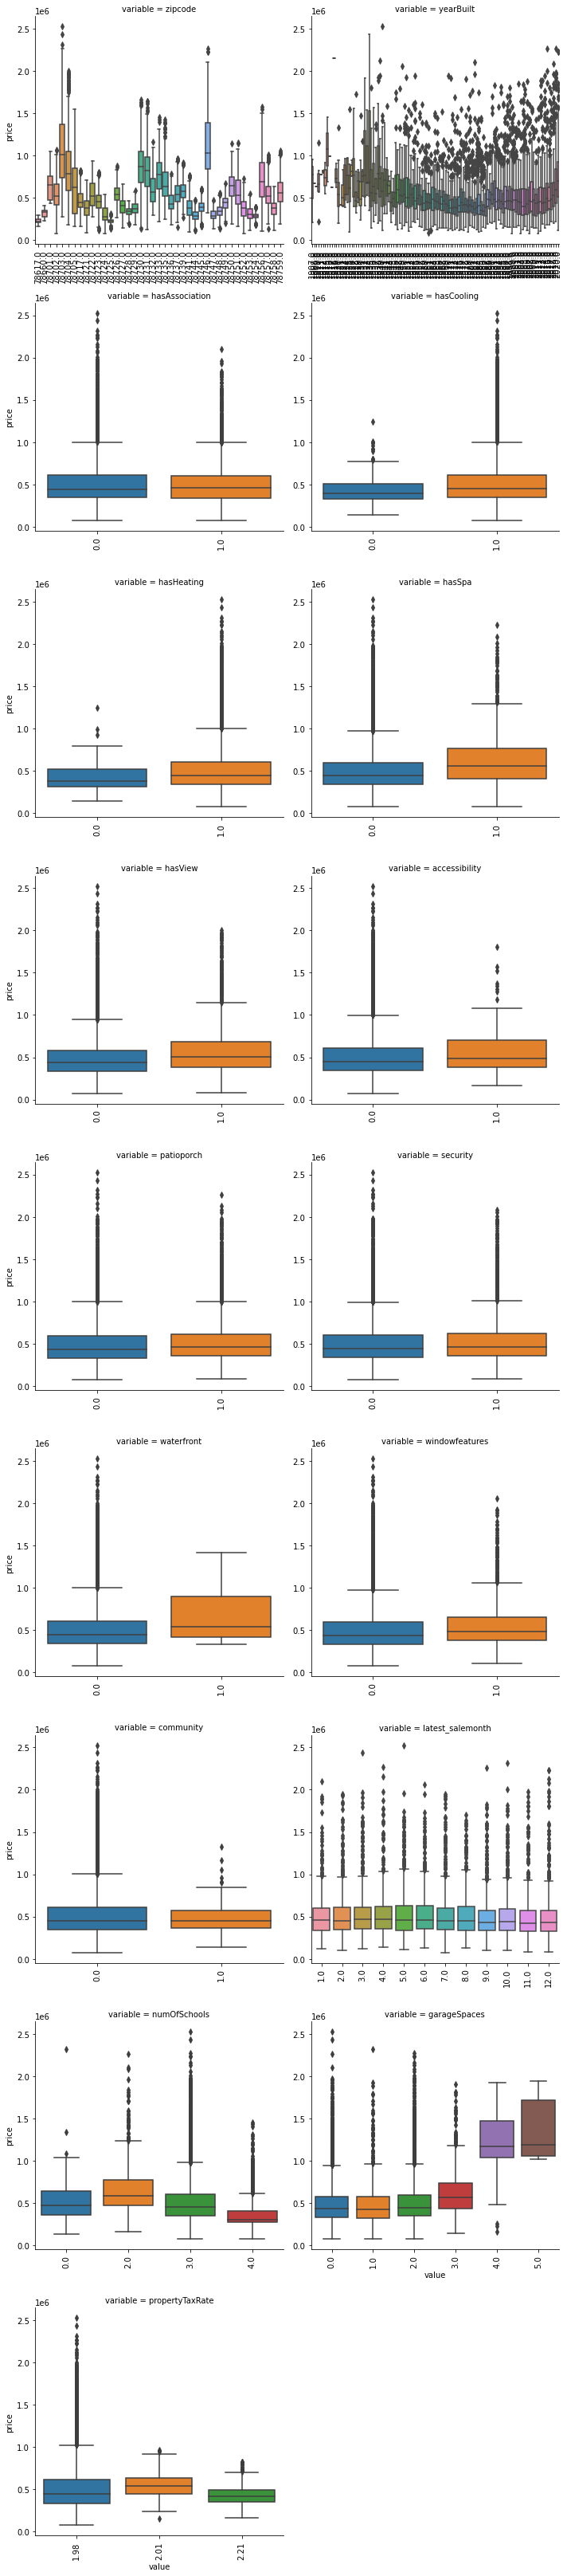

In [689]:
# adding price to our dataframe so that we can do some visualizations    

df_categoricals['price'] = train_data['price']

# plot our categoricals as box plots vs price
def boxplot(x, y, **kwargs):
    sns.boxplot(x=x, y=y)
    x=plt.xticks(rotation=90)
    
f = pd.melt(df_categoricals, id_vars=['price'], value_vars=categories)
g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False, size=5)
g = g.map(boxplot, "value", "price")

df_categoricals.drop('price', axis=1, inplace=True)

In [690]:
# there is only ONE listing with 5 schools, so we will change that one to 4
df_categoricals.loc[df_categoricals['numOfSchools']==5, 'numOfSchools'] = 4

# binning our year built bins

num_bins = 30
labels = np.array(range(1,num_bins+1))
df_categoricals["year_block"] = pd.qcut(df_categoricals['yearBuilt'], q=num_bins, labels=labels)

df_categoricals.drop('yearBuilt', axis=1, inplace=True)

# telling Pandas that these columns are categoricals
for item in df_categoricals.columns:
    df_categoricals[item] = df_categoricals[item].astype('category')
    
# make a processed bins file for use with linear regression
# We're making TWO categorical sets. One is high one hot encoding. One is low one hot encoding, and the 
# categoricals in that one will be target encoded as continuous instead

high_one_hot_cat =  ['zipcode', 'year_block', 'hasAssociation', 
                 'hasCooling', 'hasHeating', 'hasSpa', 'hasView', 
                 'accessibility', 'patioporch', 'security', 'numOfSchools',
              'waterfront', 'windowfeatures', 'community', 'latest_salemonth',
                    'garageSpaces', 'propertyTaxRate', ]
low_one_hot_cat =  ['hasAssociation', 
                'hasCooling', 'hasHeating', 'hasSpa', 
                'hasView', 'accessibility', 'patioporch', 'numOfSchools',
                'security', 'waterfront', 'windowfeatures', 'community', 'garageSpaces', 'propertyTaxRate', ]

df_cats_high_one_hot = pd.get_dummies(df_categoricals[high_one_hot_cat], prefix=high_one_hot_cat, drop_first=True)
df_cats_low_one_hot = pd.get_dummies(df_categoricals[low_one_hot_cat], prefix=low_one_hot_cat, drop_first=True)

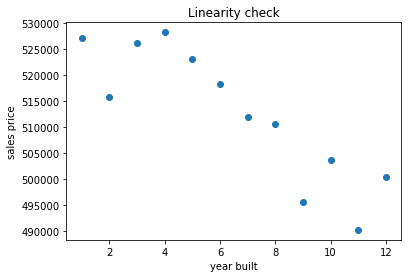

In [691]:
# Checking out our mean sales price for year built scattered versus price shows a polynomial relationship

yearly_prices = train_data.groupby('latest_salemonth')['price'].mean()

plt.scatter(yearly_prices.index, yearly_prices)
plt.title("Linearity check")
plt.xlabel('year built')
plt.ylabel('sales price')
plt.show()

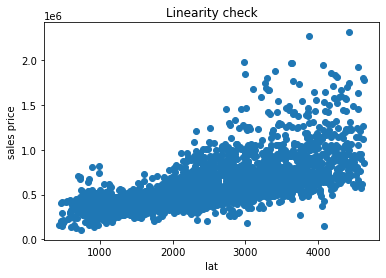

In [692]:
# Checking out our mean sales price for latitude  scattered versus price shows a polynomial relationship
lat_prices = train_data.groupby('livingAreaSqFt')['price'].mean()

plt.scatter(lat_prices.index, lat_prices)
plt.title("Linearity check")
plt.xlabel('lat')
plt.ylabel('sales price')
plt.show()

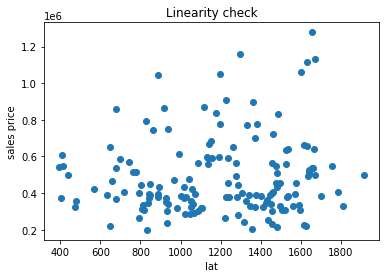

In [693]:
# Checking out our mean sales price for average school size, scattered versus price shows a polynomial relationship
lat_prices = train_data.groupby('avgSchoolSize')['price'].mean()

plt.scatter(lat_prices.index, lat_prices)
plt.title("Linearity check")
plt.xlabel('lat')
plt.ylabel('sales price')
plt.show()

In [694]:
def test_feature_combinations(price, variables):
    
    # select our estimator and our cross validation plan
    regression = LinearRegression()
    cv = RepeatedKFold(n_splits=5, n_repeats=2, random_state=1)
    
    # prepare our scoring dataframe
    scoring_df = pd.DataFrame()
    
    # prepare our lists to store our features and scores as we iterate
    scores = []
    feature1 = []
    feature2 = []
    
    # Get a list of all of our features, and remove our target variable 'price' from the list
    features = list(variables.columns)

    # make a list of all of our possible feature combinations
    feature_combos = itertools.combinations(features, 2)
    feature_combos = list(feature_combos)
    
    # set our y-value as our target variable
    y = price
    
    # prepare our x-value with our independent variables. We do an initial split here in order to run a 
    # linear regression to get a base r^2 on our basic model without interactions
    X = variables
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=randomstate)
    base_score = round(np.mean(cross_val_score(regression, X_train, y_train, scoring='r2', cv=cv)), 4)   
    print("Model base score is ",base_score)
    
    # now we run the regression on each feature combo
    for feature in feature_combos:
        feat1, feat2 = feature[0], feature[1]
        
        # create the test interaction on our data set
        variables['test_interaction'] = variables[feat1] * variables[feat2]
        # create a new X which includes the test interaction and drops our target value
        X = variables
        # make a new split so that our x-splits include the test interaction
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=randomstate)
        
        # Run a linear regression with cross-val just like our base model, and append the score to our scores list
        new_score = round(np.mean(cross_val_score(regression, X_train, y_train, scoring='r2', cv=cv)), 4)
        scores.append(new_score)
        # put feature 1 on a list
        feature1.append(feat1)
        # put feature 2 on a list
        feature2.append(feat2)
        print(feat1, feat2, new_score)
        
        
    
    # load all of our lists into the scoring dataframe
    scoring_df['feature1'] = feature1
    scoring_df['feature2'] = feature2
    scoring_df['scores'] = scores
    scoring_df['improvement'] = scoring_df['scores'] - base_score
    variables.drop('test_interaction', axis=1, inplace=True)
    
    # return our scoring dataframe to the function
    return scoring_df

In [695]:
continuous = ['numPriceChanges', 
            'livingAreaSqFt', 'avgSchoolDistance', 
              'avgSchoolRating', 'avgSchoolSize', 'numOfBedrooms', 
              'numOfStories', 'numOfPhotos', 
              'numOfAppliances', 'latest_salemonth',
             ] 

x_continuous = train_data[continuous]
x_continuous['price'] = train_data['price']

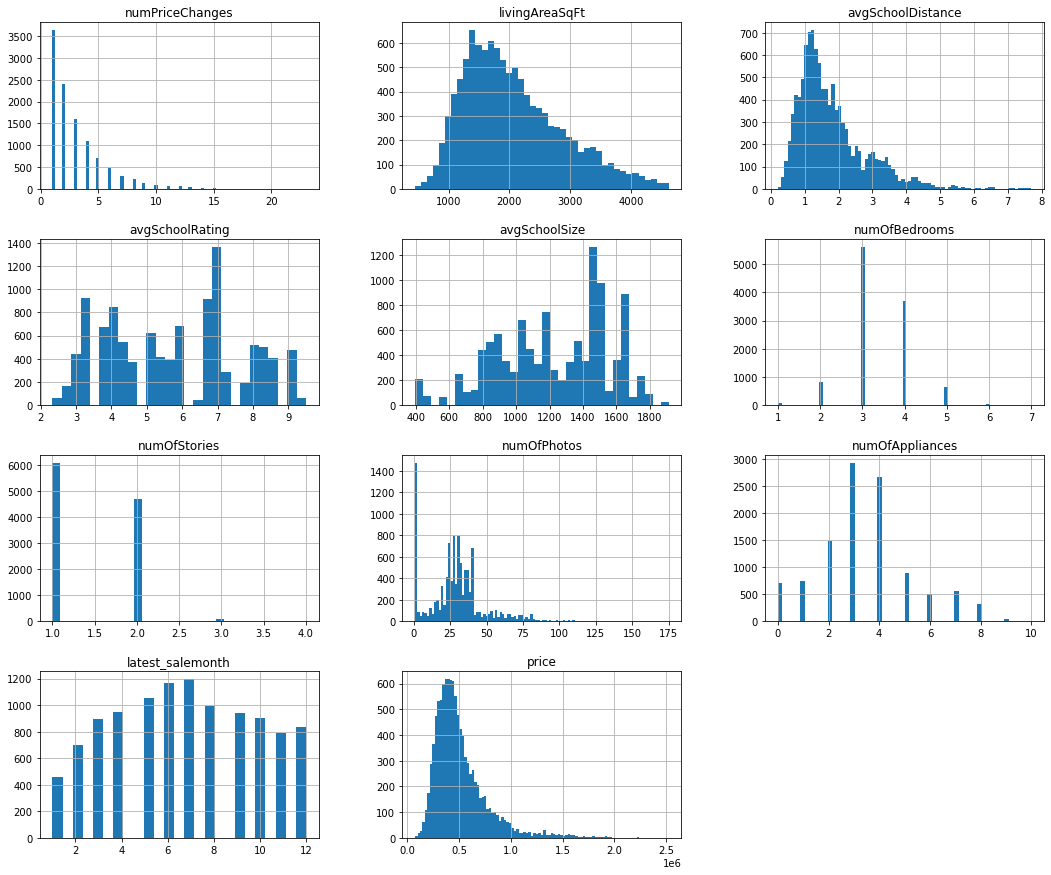

In [696]:
# check out our histograms

x_continuous.hist(figsize=(18,15), bins='auto');

In [697]:
holdout_categoricals = holdout[categories]

# binning our year built bins
holdout_categoricals["year_block"], year_bins = pd.qcut(holdout_categoricals['yearBuilt'], q=num_bins, retbins=True, labels=labels)

holdout_categoricals.drop('yearBuilt', axis=1, inplace=True)

# telling Pandas that these columns are categoricals
for item in holdout_categoricals.columns:
    holdout_categoricals[item] = holdout_categoricals[item].astype('category')

# make a processed bins file for use with linear regression
df_cats_high_one_hot_holdout = pd.get_dummies(holdout_categoricals[high_one_hot_cat], prefix=high_one_hot_cat, drop_first=True)
df_cats_low_one_hot_holdout = pd.get_dummies(holdout_categoricals[low_one_hot_cat], prefix=low_one_hot_cat, drop_first=True)

In [698]:
x_continuous.loc[x_continuous['numOfAppliances']==0, 'numOfAppliances'] = .1

# log transform
log_continuous = np.log(x_continuous)

# standardize all of our values with scikit-learn StandardScaler
scaler = StandardScaler()

#transformed_scaled_continuous = pd.DataFrame(scaler.fit_transform(x_train_cont_log),columns = x_train_cont_log.columns)
scaled_continuous = pd.DataFrame(scaler.fit_transform(log_continuous),columns = log_continuous.columns)
scaled_continuous.head(5)

# make a processed bins file for use with linear regressiona
# We're making TWO continuous sets. One is high one hot encoding. One is low one hot encoding, and includes the 
# categoricals that are target encoded as continuous instead

high_one_hot_cont =  ['numPriceChanges', 
               'livingAreaSqFt', 'avgSchoolDistance', 
              'avgSchoolRating', 'avgSchoolSize', 'numOfBedrooms', 
              'numOfStories', 'numOfPhotos', 
              'numOfAppliances']
low_one_hot_cont =  ['numPriceChanges', 
               'livingAreaSqFt', 'avgSchoolDistance', 
              'avgSchoolRating', 'avgSchoolSize', 'numOfBedrooms', 
              'numOfStories', 'numOfPhotos', 
              'numOfAppliances',  
             ]

df_cont_high_one_hot = scaled_continuous[high_one_hot_cont]
df_cont_low_one_hot = scaled_continuous[low_one_hot_cont]

In [699]:
# categoricals that are target encoded as continuous instead

high_one_hot_cont =  ['numPriceChanges', 
               'livingAreaSqFt', 'avgSchoolDistance', 
              'avgSchoolRating', 'avgSchoolSize', 'numOfBedrooms', 
              'numOfStories', 'numOfPhotos', 
              'numOfAppliances', ]
low_one_hot_cont =  ['numPriceChanges', 
               'livingAreaSqFt', 'avgSchoolDistance', 
              'avgSchoolRating', 'avgSchoolSize', 'numOfBedrooms', 
              'numOfStories', 'numOfPhotos', 
              'numOfAppliances',  
             ]

df_cont_high_one_hot = scaled_continuous[high_one_hot_cont]
df_cont_low_one_hot = scaled_continuous[low_one_hot_cont]

In [700]:
# # a few listings weren't able to create year smooth information, so we just impute it
# holdout.loc[holdout['year_smooth'].isna(), 'year_smooth'] = train_data['year_smooth'].mean()

# holdout_continuous = holdout[continuous]

# holdout_continuous['sqft-zip'] = np.sqrt(holdout_continuous['livingAreaSqFt']) + np.sqrt(holdout_continuous['zip_smooth'])

# # We're going to log transform our continuous variables, so we need to add a slight number to our zero values
# holdout_continuous.loc[holdout_continuous['numOfAppliances']==0, 'numOfAppliances'] = .1

# # log transform
# log_continuous = np.log(holdout_continuous)

# scaled_holdout_continuous = pd.DataFrame(scaler.transform(log_continuous),columns = log_continuous.columns)

# # making our two continuous sets
# df_cont_high_one_hot_holdout = scaled_holdout_continuous[high_one_hot_cont]
# df_cont_low_one_hot_holdout = scaled_holdout_continuous[low_one_hot_cont]

# # adding polynomial features
# month_poly = create_polynomial_array(df_cont_low_one_hot_holdout, 'month_smooth',2)
# df_cont_low_one_hot_holdout['month1'] = month_poly[1]

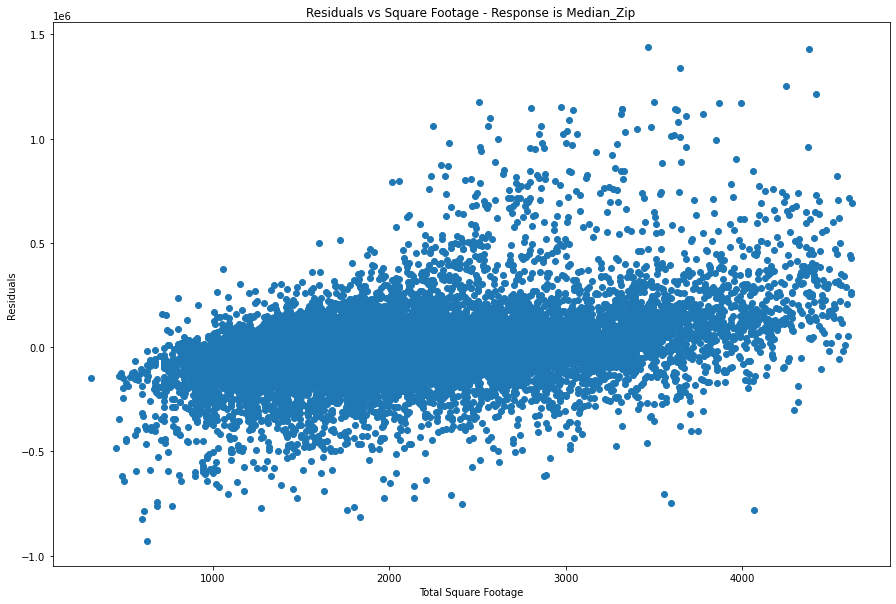

In [701]:
x, y = np.array(df['median_zip']).reshape(-1,1), df['price']
z = np.array(df['livingAreaSqFt']).reshape(-1,1)

model = LinearRegression()
model.fit(x, y)

test_predictions = model.predict(x)

residuals = y - test_predictions

fig = plt.figure(figsize=(15,10))

# Add labels for x and y axes
plt.xlabel('Total Square Footage')
plt.ylabel('Residuals')

# Add a title for the plot
plt.title('Residuals vs Square Footage - Response is Median_Zip')


plt.scatter(z, residuals, label="sample");

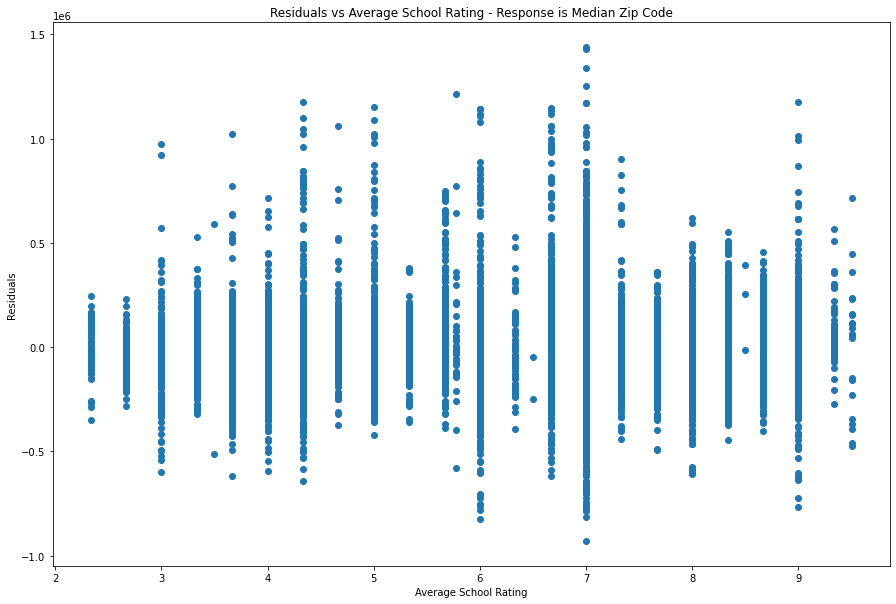

In [702]:
x, y = np.array(df['median_zip']).reshape(-1,1), df['price']
z = np.array(df['avgSchoolRating']).reshape(-1,1)

model = LinearRegression()
model.fit(x, y)

test_predictions = model.predict(x)

residuals = y - test_predictions

fig = plt.figure(figsize=(15,10))

# Add labels for x and y axes
plt.xlabel('Average School Rating')
plt.ylabel('Residuals')

# Add a title for the plot
plt.title('Residuals vs Average School Rating - Response is Median Zip Code')


plt.scatter(z, residuals, label="sample");

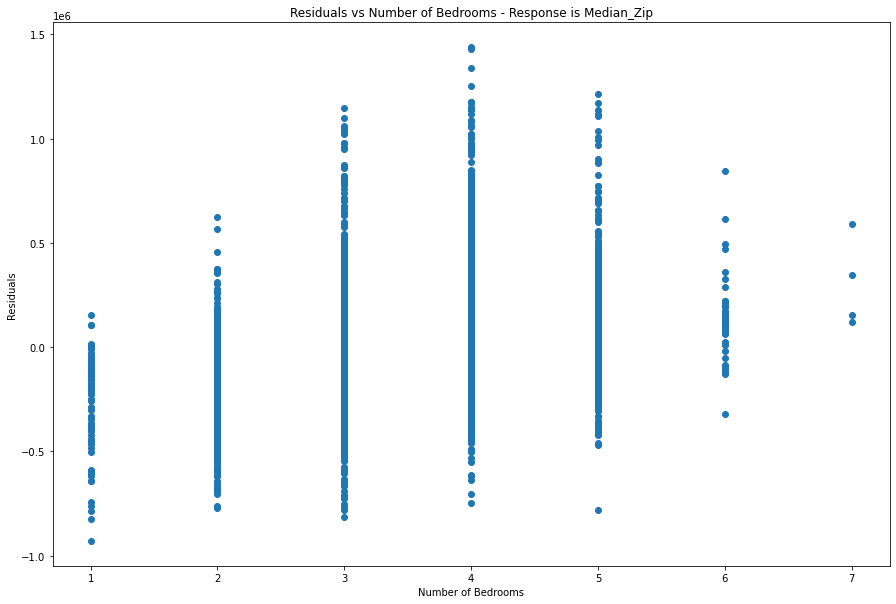

In [703]:
x, y = np.array(df['median_zip']).reshape(-1,1), df['price']
z = np.array(df['numOfBedrooms']).reshape(-1,1)

model = LinearRegression()
model.fit(x, y)

test_predictions = model.predict(x)

residuals = y - test_predictions

fig = plt.figure(figsize=(15,10))

# Add labels for x and y axes
plt.xlabel('Number of Bedrooms')
plt.ylabel('Residuals')

# Add a title for the plot
plt.title('Residuals vs Number of Bedrooms - Response is Median_Zip')

plt.scatter(z, residuals, label="sample");

In [704]:
# put together our basic feature set and preprocess

# one-hot encode categorical
base_cat = pd.DataFrame()
base_cat['zipcode'] = df['zipcode']
base_cat['zipcode'] = base_cat['zipcode'].astype('category')
base_cat_processed = pd.get_dummies(base_cat['zipcode'], prefix='zipcode', drop_first=True)
base_cat_processed.reset_index(inplace=True)
base_cat_processed.drop('index', axis=1, inplace=True)

# log transform and standard scale our continuous
base_cont = df[['avgSchoolRating', 'livingAreaSqFt', 'numOfBathrooms']]
base_cont = np.log(base_cont)
scaler = StandardScaler()
base_cont_processed = pd.DataFrame(scaler.fit_transform(base_cont),columns = base_cont.columns)

#join cat and cont into predictor data frame
x_base_set = base_cont_processed.join([base_cat_processed], how='inner') 

# train/test split
x_base_train, x_base_test = train_test_split(x_base_set, test_size=0.2, random_state=randomstate)

In [705]:
# prepare dictionary to store results
models = {}
models['Models'] = []
models['r2'] = []
models['mae'] = []
models['rmse'] = []

In [706]:
def make_model_log(model, train, test, y_train, y_test, title):
    
    model.fit(train, y_train)
    cv_5 = cross_val_score(model, train, y_train, cv=5)
    r2 = round(cv_5.mean()*100,2)
    
    test_predictions = model.predict(test)
    
    # reverse log transform our predicted values
    test_predictions_unscaled = np.exp(test_predictions).astype(int)
    test_predictions_unscaled = test_predictions_unscaled.flatten()
    
    test_actual = np.exp(y_test)
    
    # get residuals
    residuals = test_actual - test_predictions_unscaled

    fig = plt.figure(figsize=(20,15))
    plt.scatter(test_predictions_unscaled, residuals)
    plt.show()
    
    # Calculate our errors
    mae = round(mean_absolute_error(test_actual, test_predictions_unscaled), 2)
    rmse = round(np.sqrt(mean_squared_error(test_actual, test_predictions_unscaled)), 2)

    # append our results to our lists
    models['Models'].append(title)
    models['r2'].append(r2)
    models['mae'].append(mae)
    models['rmse'].append(rmse)

    print("R2: ", r2, "\nMAE: ", mae, "\nRMSE: ", rmse, "\n{} predictors used for this model".format(train.shape[1]))

In [708]:
def make_model_nolog(model, train, test, y_train, y_test, title):
    
    model.fit(train, y_train)
    cv_5 = cross_val_score(model, train, y_train, cv=5)
    r2 = round(cv_5.mean()*100,2)
    
    test_predictions = model.predict(test)

    residuals = y_test - test_predictions

    fig = plt.figure(figsize=(20,15))
    plt.scatter(test_predictions, residuals)
    plt.show()
    
    # Calculate our errors
    mae = round(mean_absolute_error(test_actual, test_predictions), 2)
    rmse = round(np.sqrt(mean_squared_error(test_actual, test_predictions)), 2)

    # append our results to our lists
    models['Models'].append(title)
    models['r2'].append(r2)
    models['mae'].append(mae)
    models['rmse'].append(rmse)

    print("R2: ", r2, "\nMAE: ", mae, "\nRMSE: ", rmse, "\n{} predictors used for this model".format(train.shape[1]))

In [714]:
# put together our basic feature set and preprocess

# one-hot encode categorical
base_cat = pd.DataFrame()
base_cat['zipcode'] = df['zipcode']
base_cat['zipcode'] = base_cat['zipcode'].astype('category')
base_cat_processed = pd.get_dummies(base_cat['zipcode'], prefix='zipcode', drop_first=True)
base_cat_processed.reset_index(inplace=True)
base_cat_processed.drop('index', axis=1, inplace=True)

# log transform and standard scale our continuous
base_cont = df[['avgSchoolRating', 'livingAreaSqFt', 'numOfBathrooms', 'zipcode']]
base_cont = np.log(base_cont)
scaler = StandardScaler()
base_cont_processed = pd.DataFrame(scaler.fit_transform(base_cont),columns = base_cont.columns)

#join cat and cont into predictor data frame
x_base_set = base_cont_processed.join([base_cat_processed], how='inner') 

# train/test split
x_base_train, x_base_test = train_test_split(x_base_set, test_size=0.2, random_state=randomstate)

In [716]:
model = LinearRegression()
make_model_log(model, x_base_train, x_base_test, y_train, y_test, 'Basic LR - Top Features Only, One-Hot')

In [ ]:
R2:  71.32 
MAE:  81867.41 
RMSE:  126034.88 
44 predictors used for this model